In [ ]:
!pip install bertopic sentence-transformers umap-learn hdbscan scikit-learn pandas numpy nltk matplotlib seaborn Gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 34.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import itertools
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# --- SETUP & STOP WORDS MODIFICATION ---
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Stop words bawaan
stop_words = set(stopwords.words('english'))

# Custom Stop Words untuk BeritaLokalInggris
junk_words_news = {
    # Lokasi & Entitas Umum
    'indonesia', 'surabaya', 'jakarta', 'east', 'java', 'country', 'region',
    'university', 'universitas', 'airlangga', 'unair', 'campus',
    'state', 'national', 'international', 'department', 'faculty', 'school',

    # Media & Atribut Berita
    'jakarta', 'post', 'tempo', 'antara', 'news', 'report', 'reported', 'article',
    'source', 'published', 'media', 'press', 'release', 'page', 'website',
    'photo', 'image', 'caption', 'download', 'app', 'link', 'click', 'read',
    'copyright', 'reserved', 'rights', 'collaboration', 'foundation',

    # Kata Kerja/Keterangan Jurnalistik
    'said', 'says', 'saying', 'told', 'added', 'according', 'statement',
    'also', 'would', 'could', 'since', 'first', 'last', 'next', 'many', 'much',
    'year', 'month', 'week', 'day', 'today', 'yesterday', 'tomorrow', 'time',
    'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
    'percent', 'million', 'billion', 'number', 'total', 'average',

    # Gelar & Sapaan
    'prof', 'dr', 'mr', 'mrs', 'general', 'director', 'manager', 'head', 'chief',
    'executive', 'secretary', 'minister', 'ministry', 'rector', 'dean',
    'expert', 'lecturer', 'researcher', 'student', 'alumni'
}

stop_words.update(junk_words_news)
lemmatizer = WordNetLemmatizer()

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# --- DATA LOADING & PREPROCESSING ---
def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'[^a-zA-Z\s]', ' ', str(text).lower())
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    clean_words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words and len(w) > 2]
    return " ".join(clean_words)

try:
    import chardet

    # Detect encoding
    with open('/content/BeritaLokalInggris.csv', 'rb') as f:
        enc = chardet.detect(f.read())['encoding']
        print("Detected encoding:", enc)

    # Load data with detected encoding
    df = pd.read_csv(
        '/content/BeritaLokalInggris.csv',
        sep=';',
        on_bad_lines='skip',
        encoding=enc
    )

    # Clean & preprocess
    if 'Isi' not in df.columns:
        text_col = df.select_dtypes(include=['object']).columns[-1]
        print(f"Warning: Kolom 'Isi' tidak ditemukan. Menggunakan kolom '{text_col}'")
        df.rename(columns={text_col: 'Isi'}, inplace=True)

    df['clean_content'] = df['Isi'].apply(clean_text)
    df = df[df['clean_content'].str.len() > 10].reset_index(drop=True)

    # Data structures for modeling
    docs = df['clean_content'].tolist()
    tokens = [doc.split() for doc in docs]
    dictionary = corpora.Dictionary(tokens)
    dictionary.filter_extremes(no_below=2, no_above=0.9)
    corpus = [dictionary.doc2bow(token) for token in tokens]

    print(f"Data berhasil dimuat. Jumlah dokumen valid: {len(df)}")

except Exception as e:
    print(f"Error loading data: {e}")

Detected encoding: MacRoman
Data berhasil dimuat. Jumlah dokumen valid: 81


In [ ]:
# --- GENERATING EMBEDDINGS ---
print("--- Generating Embeddings ---")
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

# Helper functions untuk evaluasi di sel berikutnya
def calculate_coherence(topic_words_list, texts, dictionary, coherence_type='c_v'):
    if not topic_words_list: return 0.0
    try:
        cm = CoherenceModel(topics=topic_words_list, texts=texts, dictionary=dictionary, coherence=coherence_type)
        return cm.get_coherence()
    except Exception as e:
        print(f"Error: {e}")
        return 0.0

def get_sklearn_topic_words(model, feature_names, n_top_words=10):
    topic_words_list = []
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        topic_words_list.append([feature_names[i] for i in top_indices])
    return topic_words_list

# List untuk menyimpan skor semua model
all_scores = []

--- Generating Embeddings ---


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# --- 3. OPTIMASI BERTOPIC (Grid Search) ---
print("\n--- Memulai Tuning BERTopic (Ini mungkin memakan waktu) ---")

# Embedding Model (Tetap yang ringan tapi efektif)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(docs, show_progress_bar=False)

# Grid Parameter
# n_neighbors: 3-5 (fokus mikro untuk data kecil), 10-15 (fokus makro)
# min_cluster_size: 2-3 (biarkan topik kecil muncul), 5 (topik lebih umum)
params = list(itertools.product([3, 5, 10], [2, 3, 5]))

best_score = -1
best_model = None
best_params = {}
results = []

for n_neighbors, min_cluster in params:
    try:
        # 1. UMAP (Dimensi Reduksi)
        umap_model = UMAP(n_neighbors=n_neighbors, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

        # 2. HDBSCAN (Clustering)
        hdbscan_model = HDBSCAN(min_cluster_size=min_cluster, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

        # 3. Vectorizer (KUNCI PERBAIKAN: N-GRAMS)
        # ngram_range=(1, 2) akan menangkap "sexual harassment" sebagai satu kesatuan
        vectorizer_model = CountVectorizer(stop_words=list(stop_words), min_df=2, ngram_range=(1, 2))

        # Train Model
        topic_model = BERTopic(
            embedding_model=embedding_model,
            umap_model=umap_model,
            hdbscan_model=hdbscan_model,
            vectorizer_model=vectorizer_model,
            verbose=False
        )
        topics, probs = topic_model.fit_transform(docs, embeddings)

        # 4. OUTLIER REDUCTION (KUNCI PERBAIKAN UNTUK DATA KECIL)
        # Memaksa dokumen -1 masuk ke topik terdekat
        new_topics = topic_model.reduce_outliers(docs, topics)
        topic_model.update_topics(docs, topics=new_topics)

        # Evaluasi
        topic_info = topic_model.get_topic_info()
        valid_topics = topic_info[topic_info['Topic'] != -1]['Topic'].tolist()

        if not valid_topics: continue

        topic_words = []
        for t in valid_topics:
            words = [w[0] for w in topic_model.get_topic(t)[:10]]
            topic_words.append(words)

        # Hitung Coherence
        cm = CoherenceModel(topics=topic_words, texts=tokens, dictionary=dictionary, coherence='c_v')
        score = cm.get_coherence()

        results.append({'n_neighbors': n_neighbors, 'min_cluster': min_cluster, 'Coherence': score})

        # Simpan yang terbaik
        if score > best_score:
            best_score = score
            best_model = topic_model
            best_params = {'n_neighbors': n_neighbors, 'min_cluster': min_cluster}
            print(f"  > New Best! Params: {best_params} | Score: {score:.4f}")

    except Exception as e:
        continue

# Add BERTopic's best score to all_scores
if best_model:
    all_scores.append({'Model': 'BERTopic', 'Coherence': best_score})


# --- 4. HASIL AKHIR ---
print("\n" + "="*40)
print(f"JUARA BERTOPIC: Coherence {best_score:.4f}")
print(f"Parameter: {best_params}")
print("="*40)

if best_model:
    print("\nTopik yang Ditemukan:")
    print(best_model.get_topic_info().head(10)[['Topic', 'Count', 'Name', 'Representation']])

    # Visualisasi Jarak Antar Topik
    try:
        fig = best_model.visualize_topics()
        fig.show()
    except:
        print("Visualisasi interaktif tidak dapat ditampilkan di environment ini.")


--- Memulai Tuning BERTopic (Ini mungkin memakan waktu) ---


2025-12-15 09:55:10,401 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


  > New Best! Params: {'n_neighbors': 3, 'min_cluster': 2} | Score: 0.5644


2025-12-15 09:55:11,153 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-12-15 09:55:11,731 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-12-15 09:55:13,134 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF em

  > New Best! Params: {'n_neighbors': 10, 'min_cluster': 2} | Score: 0.5766


2025-12-15 09:55:13,882 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


  > New Best! Params: {'n_neighbors': 10, 'min_cluster': 3} | Score: 0.6119


2025-12-15 09:55:14,517 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.



JUARA BERTOPIC: Coherence 0.6119
Parameter: {'n_neighbors': 10, 'min_cluster': 3}

Topik yang Ditemukan:
   Topic  Count                                Name  \
0      0     35  0_political_people_social_economic   
1      1     33        1_covid_vaccine_test_patient   
2      2      7        2_gilang_victim_child_sexual   
3      3      6       3_doctor_foreign_medical_budi   

                                      Representation  
0  [political, people, social, economic, indonesi...  
1  [covid, vaccine, test, patient, government, he...  
2  [gilang, victim, child, sexual, police, family...  
3  [doctor, foreign, medical, budi, health, plan,...  


In [ ]:
print("\n--- Running K-Means ---")
# Reduce dimensions for K-Means
umap_KM = UMAP(n_neighbors=5, n_components=10, min_dist=0.0, metric='cosine', random_state=42)
reduced_embeddings = umap_KM.fit_transform(embeddings)

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(reduced_embeddings)
df['kmeans_cluster'] = clusters

# Extract keywords using TF-IDF per cluster
tfidf_km = TfidfVectorizer(stop_words=list(stop_words), max_df=0.9, min_df=2)
tfidf_km.fit(df['clean_content'])
features_km = tfidf_km.get_feature_names_out()

kmeans_topic_words = []
for i in range(5):
    cluster_docs = df[df['kmeans_cluster'] == i]['clean_content']
    if len(cluster_docs) == 0: continue
    cluster_tfidf = tfidf_km.transform(cluster_docs)
    mean_tfidf = np.array(cluster_tfidf.mean(axis=0)).flatten()
    top_indices = mean_tfidf.argsort()[:-11:-1]
    kmeans_topic_words.append([features_km[ind] for ind in top_indices])

cm = CoherenceModel(topics=kmeans_topic_words, texts=tokens, dictionary=dictionary, coherence='c_v')
score_kmeans = cm.get_coherence() # Renamed 'score' to 'score_kmeans' for clarity
all_scores.append({'Model': 'K-Means', 'Coherence': score_kmeans})
print(f"K-Means Coherence: {score_kmeans:.4f}")


--- Running K-Means ---
K-Means Coherence: 0.6615


In [ ]:
print("\n--- Running NMF, LDA, LSA ---")
n_topics = 5

# TF-IDF for NMF & LSA
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, stop_words=list(stop_words))
tfidf_matrix = tfidf_vectorizer.fit_transform(docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Count Vectorizer for LDA
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words=list(stop_words))
tf_matrix = tf_vectorizer.fit_transform(docs)
tf_feature_names = tf_vectorizer.get_feature_names_out()

# 1. NMF
nmf = NMF(n_components=n_topics, random_state=42, init='nndsvd').fit(tfidf_matrix)
nmf_words = get_sklearn_topic_words(nmf, tfidf_feature_names)
score_nmf = calculate_coherence(nmf_words, tokens, dictionary)
all_scores.append({'Model': 'NMF', 'Coherence': score_nmf})
print(f"NMF Coherence: {score_nmf:.4f}")

# 2. LSA
lsa = TruncatedSVD(n_components=n_topics, random_state=42).fit(tfidf_matrix)
lsa_words = get_sklearn_topic_words(lsa, tfidf_feature_names)
score_lsa = calculate_coherence(lsa_words, tokens, dictionary)
all_scores.append({'Model': 'LSA', 'Coherence': score_lsa})
print(f"LSA Coherence: {score_lsa:.4f}")

# 3. LDA
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method='online').fit(tf_matrix)
lda_words = get_sklearn_topic_words(lda, tf_feature_names)
score_lda = calculate_coherence(lda_words, tokens, dictionary)
all_scores.append({'Model': 'LDA', 'Coherence': score_lda})
print(f"LDA Coherence: {score_lda:.4f}")


--- Running NMF, LDA, LSA ---
NMF Coherence: 0.6664
LSA Coherence: 0.6055
LDA Coherence: 0.3231



=== FINAL RESULTS (Ranked by Coherence Score) ===
      Model  Coherence
2       NMF   0.666444
1   K-Means   0.661529
0  BERTopic   0.611929
3       LSA   0.605511
4       LDA   0.323122


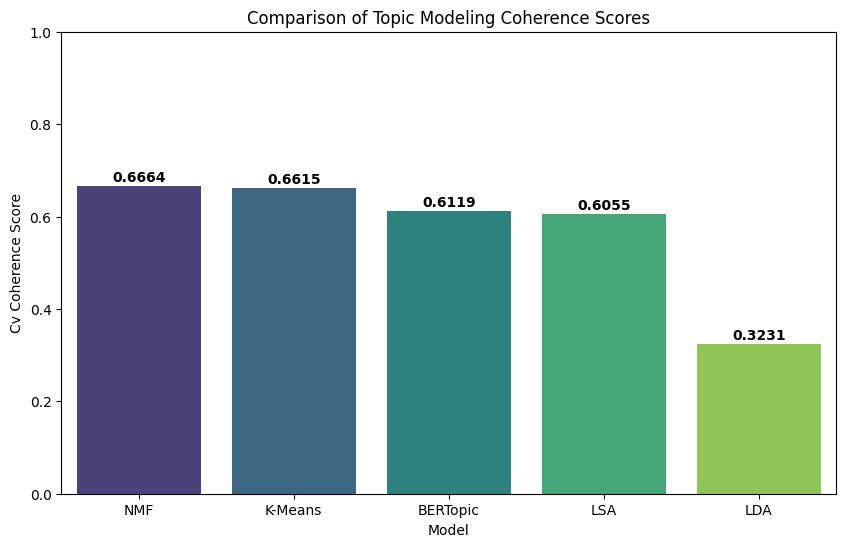


Topik dari Model Terbaik (NMF):
Topic 0: economic, digital, political, government, attack, social, indonesian, korea, people, south
Topic 1: vaccine, trial, covid, clinical, research, candidate, mrna, drug, production, phase
Topic 2: gilang, victim, sexual, police, fikris, thesis, wrapping, body, case, defendant
Topic 3: doctor, foreign, medical, budi, plan, dismissal, health, santoso, academic, freedom
Topic 4: test, covid, lab, patient, pcr, virus, robot, health, kit, sample


In [ ]:
# --- FINAL COMPARISON & VISUALIZATION ---
results_df = pd.DataFrame(all_scores).sort_values(by='Coherence', ascending=False)

print("\n=== FINAL RESULTS (Ranked by Coherence Score) ===")
print(results_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='Coherence', palette='viridis')
plt.title('Comparison of Topic Modeling Coherence Scores')
plt.ylabel('Cv Coherence Score')
plt.ylim(0, 1.0)
for i, v in enumerate(results_df['Coherence']):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')
plt.show()

# --- PRINT TOP WORDS FOR BEST MODEL ---
best_model_name = results_df.iloc[0]['Model']
print(f"\nTopik dari Model Terbaik ({best_model_name}):")

if best_model_name == 'BERTopic':
    if best_bertopic_model:
        print(best_bertopic_model.get_topic_info().head(6)[['Topic', 'Count', 'Name', 'Representation']])
elif best_model_name == 'K-Means':
    for i, words in enumerate(kmeans_topic_words):
        print(f"Cluster {i}: {', '.join(words)}")
elif best_model_name == 'NMF':
    for i, words in enumerate(nmf_words):
        print(f"Topic {i}: {', '.join(words)}")
elif best_model_name == 'LSA':
    for i, words in enumerate(lsa_words):
        print(f"Topic {i}: {', '.join(words)}")
elif best_model_name == 'LDA':
    for i, words in enumerate(lda_words):
        print(f"Topic {i}: {', '.join(words)}")

In [ ]:
print("Installing wordcloud library...")
!pip install wordcloud
print("Wordcloud library installed.")

Installing wordcloud library...
Wordcloud library installed.


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(word_list, title):
    """
    Generates and displays a word cloud from a list of words.

    Args:
        word_list (list): A list of words to include in the word cloud.
        title (str): The title for the word cloud plot.
    """
    # Convert the list of words into a single string
    text = " ".join(word_list)

    # Initialize WordCloud object with specified parameters
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate(text)

    # Display the generated image:
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

print("Defined create_wordcloud function.")

Defined create_wordcloud function.



--- Generating Word Clouds for NMF Topics ---
Generating word cloud for NMF Topic 0 Word Cloud...


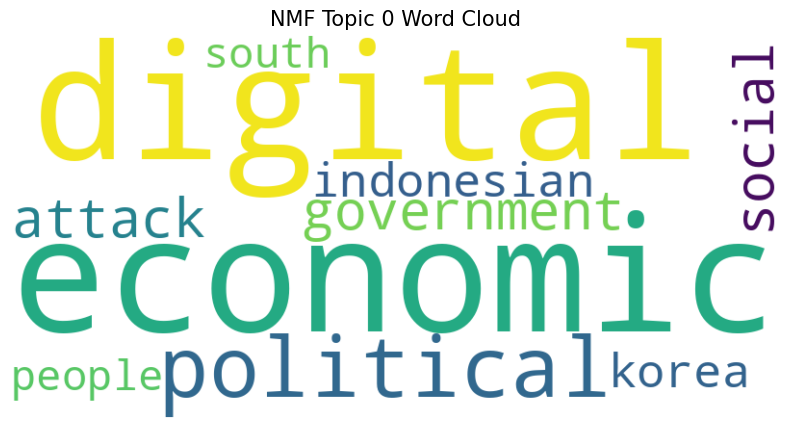

Generating word cloud for NMF Topic 1 Word Cloud...


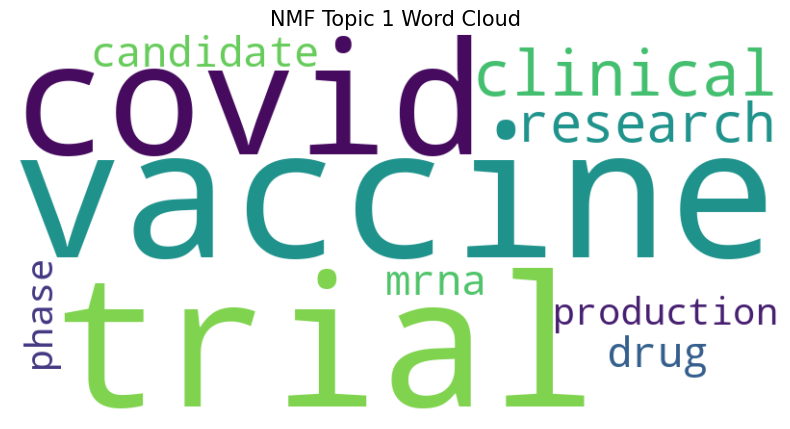

Generating word cloud for NMF Topic 2 Word Cloud...


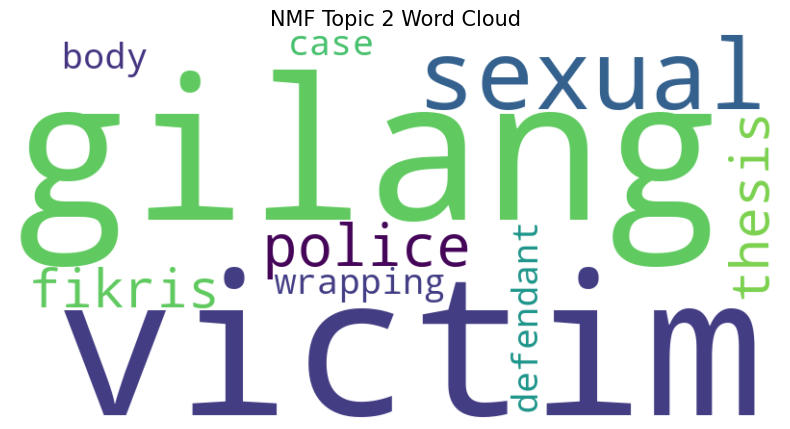

Generating word cloud for NMF Topic 3 Word Cloud...


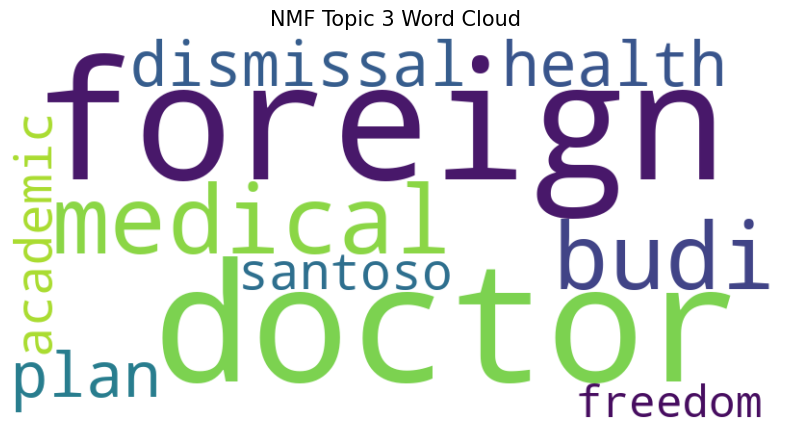

Generating word cloud for NMF Topic 4 Word Cloud...


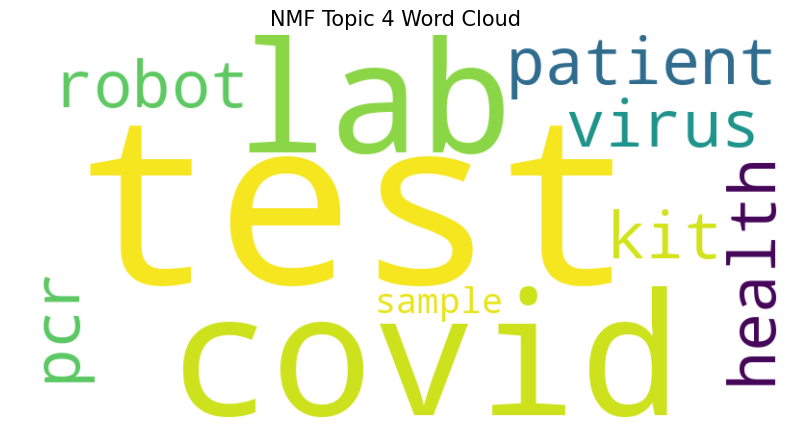

In [ ]:
print("\n--- Generating Word Clouds for NMF Topics ---")

# Accessing nmf_words from the kernel state
# nmf_words was defined in a previous cell and contains the top words for each NMF topic

if 'nmf_words' in locals() or 'nmf_words' in globals():
    for i, words in enumerate(nmf_words):
        title = f"NMF Topic {i} Word Cloud"
        print(f"Generating word cloud for {title}...")
        create_wordcloud(words, title)
else:
    print("Error: nmf_words not found. Please ensure NMF model was run successfully.")



--- Generating Word Clouds for BERTopic Topics ---
Generating word cloud for BERTopic Topic 0 Word Cloud...


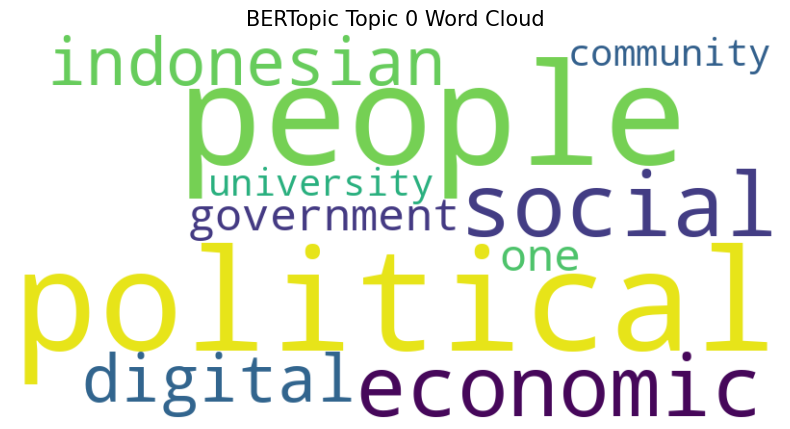

Generating word cloud for BERTopic Topic 1 Word Cloud...


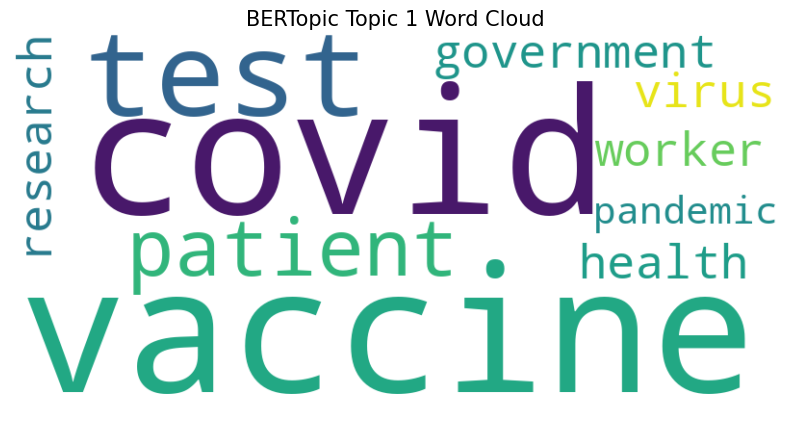

Generating word cloud for BERTopic Topic 2 Word Cloud...


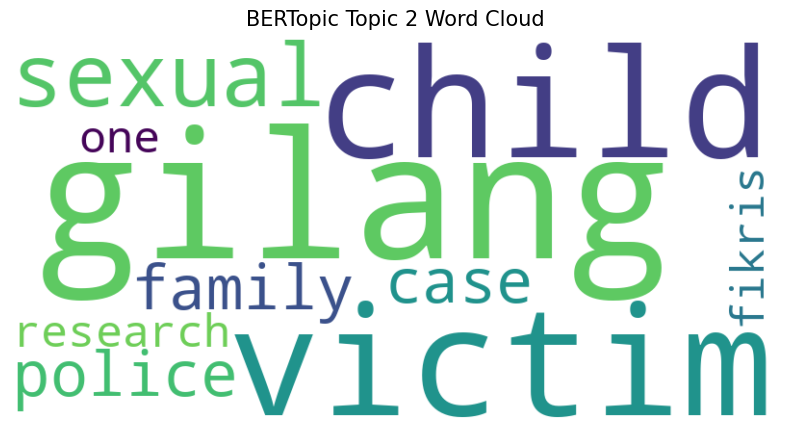

Generating word cloud for BERTopic Topic 3 Word Cloud...


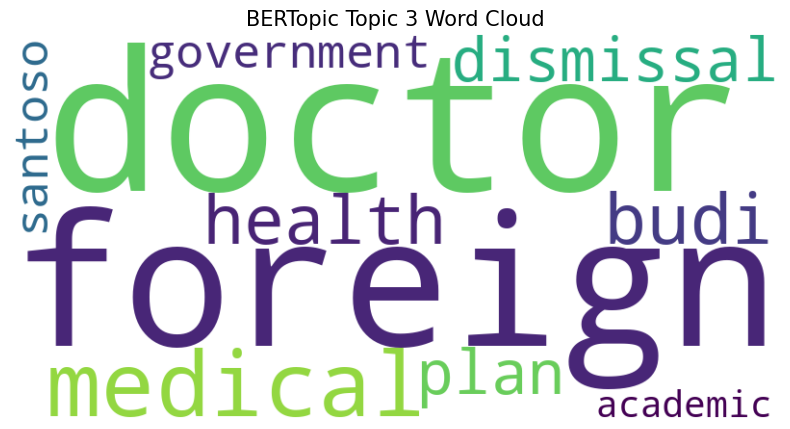

In [ ]:
print("\n--- Generating Word Clouds for BERTopic Topics ---")

# Check if best_model (BERTopic) exists
if 'best_model' in locals() and best_model is not None:
    topic_info_bertopic = best_model.get_topic_info()
    # Filter out the outlier topic (-1)
    valid_topics_bertopic = topic_info_bertopic[topic_info_bertopic['Topic'] != -1]['Topic'].tolist()

    if not valid_topics_bertopic:
        print("No valid BERTopic topics found to generate word clouds.")
    else:
        for topic_id in valid_topics_bertopic:
            # Extract top 10 words for the current topic
            words_and_scores = best_model.get_topic(topic_id)
            topic_words = [word for word, score in words_and_scores]

            if topic_words:
                title = f"BERTopic Topic {topic_id} Word Cloud"
                print(f"Generating word cloud for {title}...")
                create_wordcloud(topic_words, title)
            else:
                print(f"No words found for BERTopic Topic {topic_id}.")
else:
    print("Error: BERTopic 'best_model' not found. Please ensure the BERTopic model was run successfully.")



--- Generating Word Clouds for K-Means Topics ---
Generating word cloud for K-Means Cluster 0 Word Cloud...


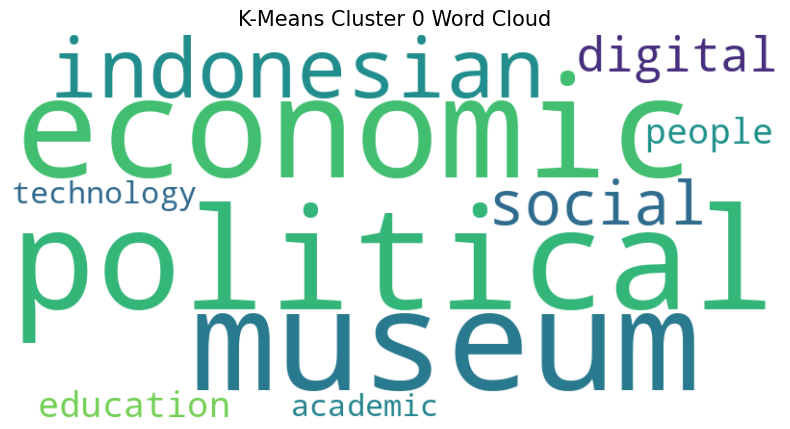

Generating word cloud for K-Means Cluster 1 Word Cloud...


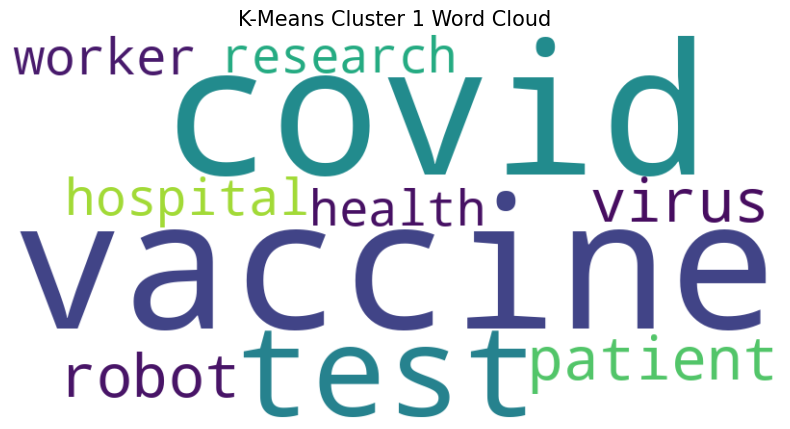

Generating word cloud for K-Means Cluster 2 Word Cloud...


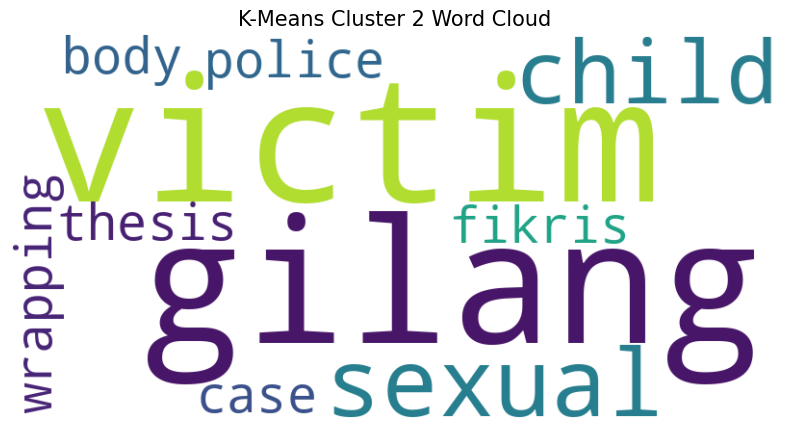

Generating word cloud for K-Means Cluster 3 Word Cloud...


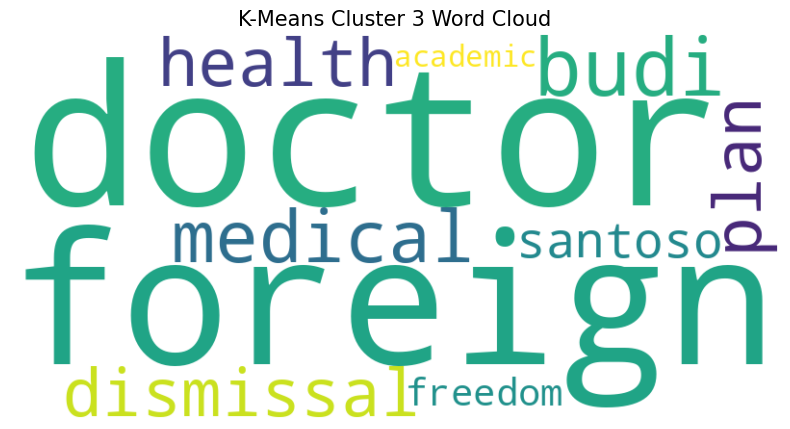

Generating word cloud for K-Means Cluster 4 Word Cloud...


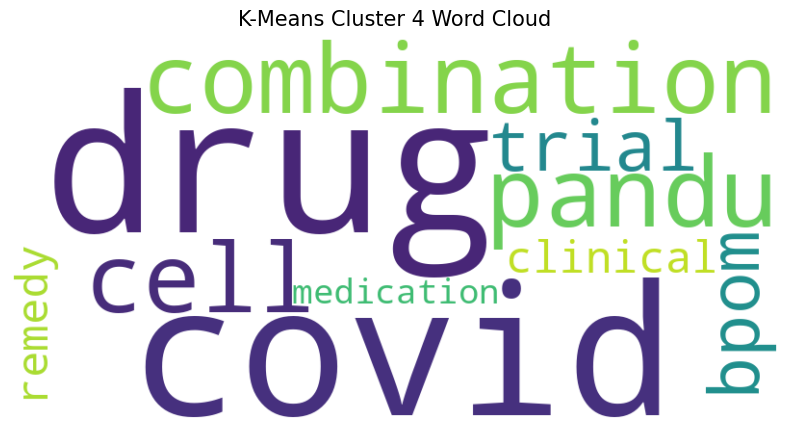

In [ ]:
print("\n--- Generating Word Clouds for K-Means Topics ---")

# Accessing kmeans_topic_words from the kernel state
# kmeans_topic_words was defined in a previous cell and contains the top words for each K-Means topic

if 'kmeans_topic_words' in locals() or 'kmeans_topic_words' in globals():
    for i, words in enumerate(kmeans_topic_words):
        title = f"K-Means Cluster {i} Word Cloud"
        print(f"Generating word cloud for {title}...")
        create_wordcloud(words, title)
else:
    print("Error: kmeans_topic_words not found. Please ensure K-Means model was run successfully.")


--- Generating Word Clouds for LSA Topics ---
Generating word cloud for LSA Topic 0 Word Cloud...


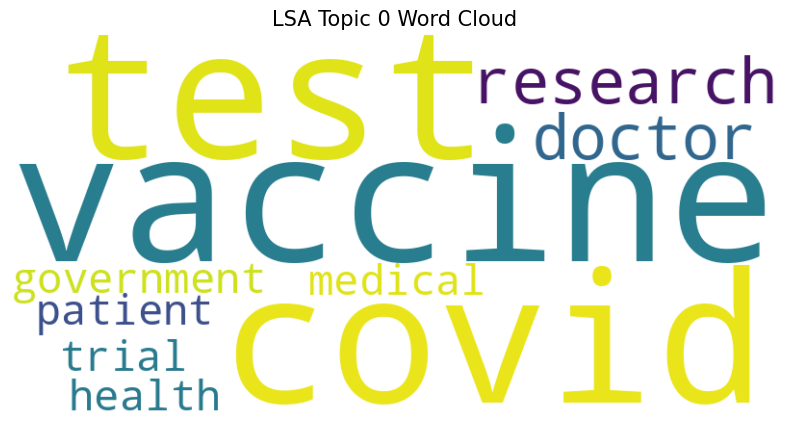

Generating word cloud for LSA Topic 1 Word Cloud...


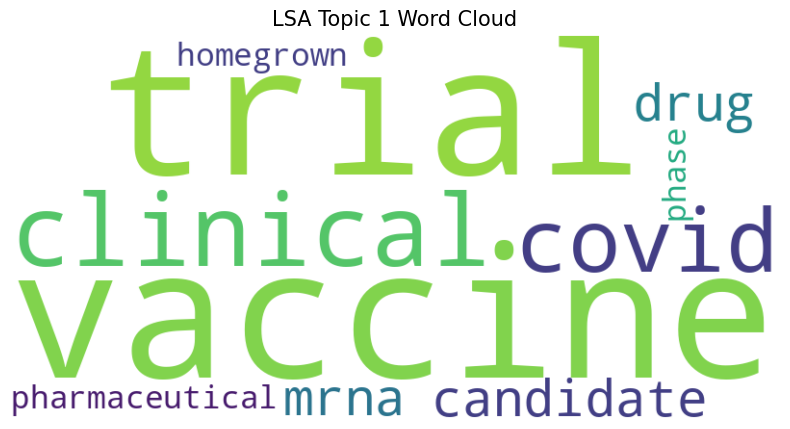

Generating word cloud for LSA Topic 2 Word Cloud...


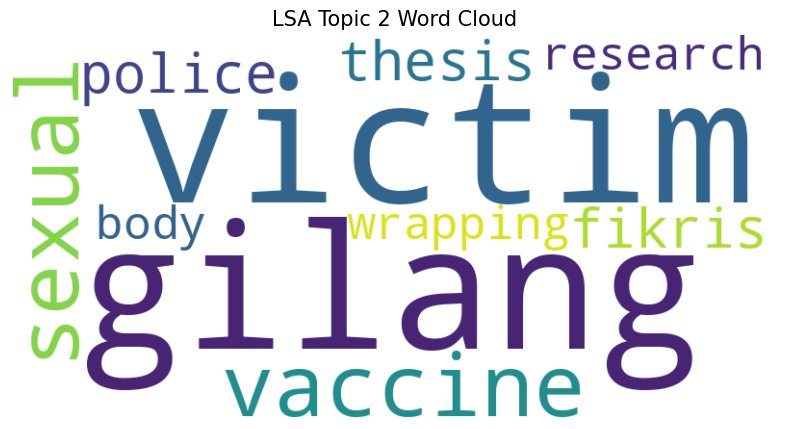

Generating word cloud for LSA Topic 3 Word Cloud...


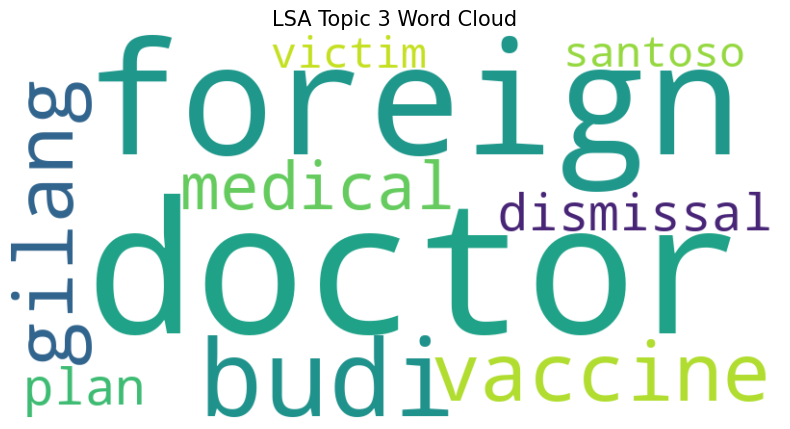

Generating word cloud for LSA Topic 4 Word Cloud...


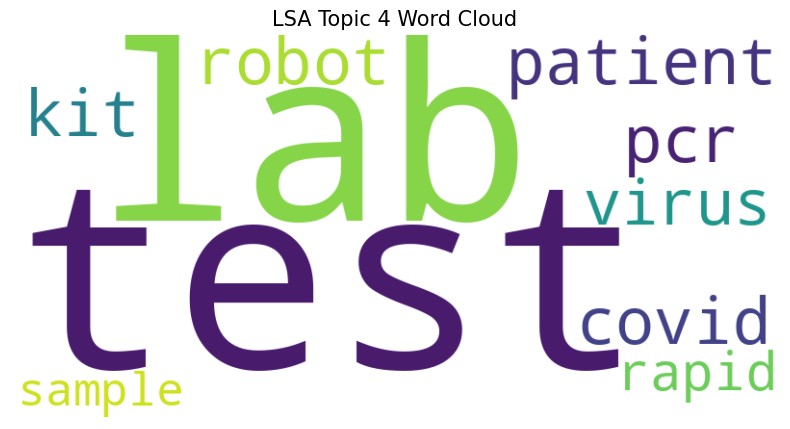

In [ ]:
print("\n--- Generating Word Clouds for LSA Topics ---")

# Accessing lsa_words from the kernel state
# lsa_words was defined in a previous cell and contains the top words for each LSA topic

if 'lsa_words' in locals() or 'lsa_words' in globals():
    for i, words in enumerate(lsa_words):
        title = f"LSA Topic {i} Word Cloud"
        print(f"Generating word cloud for {title}...")
        create_wordcloud(words, title)
else:
    print("Error: lsa_words not found. Please ensure LSA model was run successfully.")

In [ ]:
import pandas as pd
import numpy as np
import re

# --- FUNGSI PEMBERSIH TAMPILAN ---
def clean_display_text(text, max_len=200):
    if pd.isna(text):
        return ""
    text = str(text).strip()

    # PERBAIKAN: Menghilangkan spasi setelah karakter kapital pertama (Artifact Drop Cap)
    # Contoh: "T he" -> "The", "I ndividuals" -> "Individuals", "A irlangga" -> "Airlangga"
    # Regex ini mencari Huruf Kapital di awal string, diikuti spasi, lalu huruf kecil.
    text = re.sub(r'^([A-Z])\s+([a-z])', r'\1\2', text)

    # Memotong teks jika terlalu panjang
    if len(text) > max_len:
        return text[:max_len] + "..."
    return text

print("=== HASIL TOPIK & REPRESENTASI KALIMAT ASLI (DIRAPIKAN) ===\n")

# ==========================================
# 1. MODEL: BERTopic
# ==========================================
print("\n" + "="*60)
print("1. MODEL: BERTopic")
print("="*60)

if 'best_model' in locals() and best_model is not None:
    topic_info = best_model.get_topic_info()
    try:
        doc_topics = best_model.topics_
    except AttributeError:
        doc_topics, _ = best_model.transform(docs)

    valid_topics = topic_info[topic_info['Topic'] != -1]['Topic'].head(5).tolist()

    for topic_id in valid_topics:
        topic_keywords = [w[0] for w in best_model.get_topic(topic_id)][:10]
        print(f"\n[Topic {topic_id}]")
        print(f"Keywords: {', '.join(topic_keywords)}")

        indices = [i for i, x in enumerate(doc_topics) if x == topic_id]
        if indices:
            print("Contoh Kalimat Asli:")
            for i, idx in enumerate(indices[:3]):
                raw_text = df.iloc[idx]['Isi']
                print(f"  {i+1}. {clean_display_text(raw_text)}")
        else:
            print("  Tidak ada dokumen representatif.")
else:
    print("Model BERTopic belum dijalankan/tersedia.")

# ==========================================
# 2. MODEL: K-Means
# ==========================================
print("\n" + "="*60)
print("2. MODEL: K-Means")
print("="*60)

if 'kmeans' in locals() and 'kmeans_topic_words' in locals():
    for cluster_id, keywords in enumerate(kmeans_topic_words):
        print(f"\n[Cluster {cluster_id}]")
        print(f"Keywords: {', '.join(keywords)}")

        cluster_docs = df[df['kmeans_cluster'] == cluster_id]
        sample_indices = cluster_docs.index[:3]

        print("Contoh Kalimat Asli:")
        for i, idx in enumerate(sample_indices):
            raw_text = df.loc[idx, 'Isi']
            print(f"  {i+1}. {clean_display_text(raw_text)}")
else:
    print("Hasil K-Means belum tersedia.")

# ==========================================
# 3. MODEL: NMF
# ==========================================
print("\n" + "="*60)
print("3. MODEL: NMF")
print("="*60)

if 'nmf' in locals() and 'tfidf_matrix' in locals() and 'nmf_words' in locals():
    nmf_W = nmf.transform(tfidf_matrix)
    for topic_id, keywords in enumerate(nmf_words):
        print(f"\n[Topic {topic_id}]")
        print(f"Keywords: {', '.join(keywords)}")

        top_doc_indices = nmf_W[:, topic_id].argsort()[::-1][:3]
        print("Contoh Kalimat Asli:")
        for i, idx in enumerate(top_doc_indices):
            raw_text = df.iloc[idx]['Isi']
            print(f"  {i+1}. {clean_display_text(raw_text)}")
else:
    print("Hasil NMF belum tersedia.")

# ==========================================
# 4. MODEL: LDA
# ==========================================
print("\n" + "="*60)
print("4. MODEL: LDA")
print("="*60)

if 'lda' in locals() and 'tf_matrix' in locals() and 'lda_words' in locals():
    lda_W = lda.transform(tf_matrix)
    for topic_id, keywords in enumerate(lda_words):
        print(f"\n[Topic {topic_id}]")
        print(f"Keywords: {', '.join(keywords)}")

        top_doc_indices = lda_W[:, topic_id].argsort()[::-1][:3]
        print("Contoh Kalimat Asli:")
        for i, idx in enumerate(top_doc_indices):
            raw_text = df.iloc[idx]['Isi']
            print(f"  {i+1}. {clean_display_text(raw_text)}")
else:
    print("Hasil LDA belum tersedia.")

# ==========================================
# 5. MODEL: LSA
# ==========================================
print("\n" + "="*60)
print("5. MODEL: LSA")
print("="*60)

if 'lsa' in locals() and 'tfidf_matrix' in locals() and 'lsa_words' in locals():
    lsa_W = lsa.transform(tfidf_matrix)
    for topic_id, keywords in enumerate(lsa_words):
        print(f"\n[Topic {topic_id}]")
        print(f"Keywords: {', '.join(keywords)}")

        top_doc_indices = lsa_W[:, topic_id].argsort()[::-1][:3]
        print("Contoh Kalimat Asli:")
        for i, idx in enumerate(top_doc_indices):
            raw_text = df.iloc[idx]['Isi']
            print(f"  {i+1}. {clean_display_text(raw_text)}")
else:
    print("Hasil LSA belum tersedia.")

=== HASIL TOPIK & REPRESENTASI KALIMAT ASLI (DIRAPIKAN) ===


1. MODEL: BERTopic

[Topic 0]
Keywords: political, people, social, economic, indonesian, digital, government, one, university, community
Contoh Kalimat Asli:
  1. Indonesia and South Korea have maintained bilateral ties for more than 50 years, with relentless efforts conducted to spur close bilateral relationship, especially in economics, trade and investment. ...
  2. Bilateral cooperation between Indonesia and South Korea has been established for over 50 years. The close relationship between the two countries continues to be promoted, especially in the sectors of ...
  3. Amuseum in the East Java city of Surabaya aims to enlighten people about Indonesian funeral rituals and their correlation to other fields, including the economy and culture. The†Ethnography Museum and...

[Topic 1]
Keywords: covid, vaccine, test, patient, government, health, virus, research, worker, pandemic
Contoh Kalimat Asli:
  1. Airlangga University 

# Task
Perform a grid search to optimize the number of topics (k from 2 to 15) for K-Means, NMF, LSA, and LDA models, calculating and storing the C_v coherence score for each configuration. Then, generate a line plot visualizing the coherence scores against the number of topics for these models. Finally, compare the best coherence scores across all models (including BERTopic) using a bar chart and display the top words for the overall best-performing model.

## Perform Grid Search for K-Means, NMF, LSA, and LDA

### Subtask:
Iterate through a range of topic numbers (k from 2 to 15) for K-Means, NMF, LSA, and LDA models. For each 'k', train the respective topic model, calculate its C_v coherence score, and store the model name, 'k' value, and coherence score. Keep track of the best 'k' and its coherence score for each model. Finally, update the `all_scores` list with the highest coherence found for each model.


**Reasoning**:
The subtask requires performing a grid search for K-Means, NMF, LSA, and LDA models to find the optimal number of topics (k) based on coherence scores. This code block initializes variables, iterates through k from 2 to 15 for each model, trains the model, calculates coherence, tracks the best k and score, and finally updates the 'all_scores' list with the best coherence for each model.



In [ ]:
print("\n--- Performing Grid Search for K-Means, NMF, LSA, and LDA ---\n")

k_range = range(2, 16) # k from 2 to 15

# --- 1. Initialize variables ---
# For K-Means
kmeans_coherence_per_k = []
best_kmeans_score = -1
best_k_kmeans = -1

# For NMF
nmf_coherence_per_k = []
best_nmf_score = -1
best_k_nmf = -1
best_nmf_model_for_display = None

# For LSA
lsa_coherence_per_k = []
best_lsa_score = -1
best_k_lsa = -1
best_lsa_model_for_display = None

# For LDA
lda_coherence_per_k = []
best_lda_score = -1
best_k_lda = -1
best_lda_model_for_display = None

# For BERTopic (new for k-based grid search)
bertopic_coherence_per_k = []
best_bertopic_score_k = -1
best_k_bertopic = -1

# --- Grid Search for K-Means ---
print("Running Grid Search for K-Means...")
for k in k_range:
    try:
        # Ensure reduced_embeddings is available and correctly calculated for K-Means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(reduced_embeddings)

        current_kmeans_topic_words = []
        for i in range(k):
            cluster_docs_indices = df.index[clusters == i]
            if len(cluster_docs_indices) == 0: # Skip empty clusters
                continue
            cluster_docs_content = df.loc[cluster_docs_indices, 'clean_content']

            if len(cluster_docs_content) > 0:
                cluster_tfidf = tfidf_km.transform(cluster_docs_content)
                if cluster_tfidf.shape[0] > 0:
                    mean_tfidf = np.array(cluster_tfidf.mean(axis=0)).flatten()
                    n_top_words = min(10, len(features_km))
                    top_indices = mean_tfidf.argsort()[:-n_top_words - 1:-1]
                    current_kmeans_topic_words.append([features_km[ind] for ind in top_indices])

        if not current_kmeans_topic_words: # If no topic words were extracted, skip coherence calculation
            score = 0.0
        else:
            score = calculate_coherence(current_kmeans_topic_words, tokens, dictionary, coherence_type='c_v')

        kmeans_coherence_per_k.append({'k': k, 'coherence': score})

        if score > best_kmeans_score:
            best_kmeans_score = score
            best_k_kmeans = k

    except Exception as e:
        print(f"Error in K-Means for k={k}: {e}")
        kmeans_coherence_per_k.append({'k': k, 'coherence': 0.0}) # Add 0 for failed attempts

# --- Grid Search for NMF ---
print("Running Grid Search for NMF...")
for k in k_range:
    try:
        nmf = NMF(n_components=k, random_state=42, init='nndsvd')
        nmf.fit(tfidf_matrix)
        current_nmf_words = get_sklearn_topic_words(nmf, tfidf_feature_names)
        score = calculate_coherence(current_nmf_words, tokens, dictionary, coherence_type='c_v')
        nmf_coherence_per_k.append({'k': k, 'coherence': score})

        if score > best_nmf_score:
            best_nmf_score = score
            best_k_nmf = k
            best_nmf_model_for_display = nmf # Store the best model

    except Exception as e:
        print(f"Error in NMF for k={k}: {e}")
        nmf_coherence_per_k.append({'k': k, 'coherence': 0.0}) # Add 0 for failed attempts

# --- Grid Search for LSA ---
print("Running Grid Search for LSA...")
for k in k_range:
    try:
        lsa = TruncatedSVD(n_components=k, random_state=42)
        lsa.fit(tfidf_matrix)
        current_lsa_words = get_sklearn_topic_words(lsa, tfidf_feature_names)
        score = calculate_coherence(current_lsa_words, tokens, dictionary, coherence_type='c_v')
        lsa_coherence_per_k.append({'k': k, 'coherence': score})

        if score > best_lsa_score:
            best_lsa_score = score
            best_k_lsa = k
            best_lsa_model_for_display = lsa # Store the best model

    except Exception as e:
        print(f"Error in LSA for k={k}: {e}")
        lsa_coherence_per_k.append({'k': k, 'coherence': 0.0}) # Add 0 for failed attempts

# --- Grid Search for LDA ---
print("Running Grid Search for LDA...")
for k in k_range:
    try:
        lda = LatentDirichletAllocation(n_components=k, random_state=42, learning_method='online')
        lda.fit(tf_matrix)
        current_lda_words = get_sklearn_topic_words(lda, tf_feature_names)
        score = calculate_coherence(current_lda_words, tokens, dictionary, coherence_type='c_v')
        lda_coherence_per_k.append({'k': k, 'coherence': score})

        if score > best_lda_score:
            best_lda_score = score
            best_k_lda = k
            best_lda_model_for_display = lda # Store the best model

    except Exception as e:
        print(f"Error in LDA for k={k}: {e}")
        lda_coherence_per_k.append({'k': k, 'coherence': 0.0}) # Add 0 for failed attempts


# --- Grid Search for BERTopic (varying nr_topics) ---
print("Running Grid Search for BERTopic (varying nr_topics)...")

# Re-initialize UMAP and HDBSCAN models with best params from initial BERTopic run (from cell 5nwyIdXdqzkq)
# These are available in `best_params`: {'n_neighbors': 10, 'min_cluster': 3}

# Make sure best_params is accessible; if not, use the values directly
bertopic_base_n_neighbors = 10 # From initial BERTopic best_params
bertopic_base_min_cluster = 3 # From initial BERTopic best_params

umap_model_for_bertopic_k_search = UMAP(n_neighbors=bertopic_base_n_neighbors, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model_for_bertopic_k_search = HDBSCAN(min_cluster_size=bertopic_base_min_cluster, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
vectorizer_model_for_bertopic_k_search = CountVectorizer(stop_words=list(stop_words), min_df=2, ngram_range=(1, 2))

# Train a base BERTopic model once
# We will deepcopy this model for each k to apply reduce_topics independently
base_bertopic_model_for_k_search = BERTopic(
    embedding_model=embedding_model, # Reuse the existing embedding_model
    umap_model=umap_model_for_bertopic_k_search,
    hdbscan_model=hdbscan_model_for_bertopic_k_search,
    vectorizer_model=vectorizer_model_for_bertopic_k_search,
    verbose=False
)

# Fit the base model once to get the initial topics and probabilities
# The `docs` and `embeddings` are available from previous cells.
initial_topics_for_k_search, initial_probs_for_k_search = base_bertopic_model_for_k_search.fit_transform(docs, embeddings)

# Iterate through k_range and apply reduce_topics
import copy # Import copy module for deepcopy

for k in k_range:
    try:
        # Create a deep copy of the fitted base model to ensure independent reductions
        bertopic_model_for_k = copy.deepcopy(base_bertopic_model_for_k_search)

        # Reduce topics to the desired 'k'
        bertopic_model_for_k.reduce_topics(docs, nr_topics=k)

        topic_info_for_k = bertopic_model_for_k.get_topic_info()
        # Filter out the outlier topic (-1) and ensure only specified k topics are considered
        # Check if the model has actually reduced to 'k' topics (or fewer if k is too high for the dataset)
        # We should only consider `valid_topics` from `get_topic_info` after reduction.

        # Get the actual number of topics after reduction
        current_num_bertopics = len(topic_info_for_k[topic_info_for_k['Topic'] != -1])

        if current_num_bertopics < 2: # Need at least 2 topics for coherence calculation to be meaningful
            bertopic_coherence_per_k.append({'k': k, 'coherence': 0.0})
            continue

        topic_words_for_k = []
        for topic_id in topic_info_for_k[topic_info_for_k['Topic'] != -1]['Topic'].tolist():
            words = [w[0] for w in bertopic_model_for_k.get_topic(topic_id)[:10]]
            topic_words_for_k.append(words)

        score_bertopic_k = calculate_coherence(topic_words_for_k, tokens, dictionary, coherence_type='c_v')
        bertopic_coherence_per_k.append({'k': k, 'coherence': score_bertopic_k})

        if score_bertopic_k > best_bertopic_score_k:
            best_bertopic_score_k = score_bertopic_k
            best_k_bertopic = k

    except Exception as e:
        print(f"Error in BERTopic for k={k}: {e}")
        bertopic_coherence_per_k.append({'k': k, 'coherence': 0.0}) # Add 0 for failed attempts


# --- Update all_scores with the best results ---
# Clear previous scores to only include the best k for each model
all_scores = []

# Add BERTopic's best score from the k-based grid search
if best_bertopic_score_k > -1:
    all_scores.append({'Model': 'BERTopic', 'Coherence': best_bertopic_score_k})
    print(f"Best BERTopic (tuned for k): k={best_k_bertopic}, Coherence={best_bertopic_score_k:.4f}")

if best_kmeans_score > -1:
    all_scores.append({'Model': 'K-Means', 'Coherence': best_kmeans_score})
    print(f"Best K-Means: k={best_k_kmeans}, Coherence={best_kmeans_score:.4f}")
if best_nmf_score > -1:
    all_scores.append({'Model': 'NMF', 'Coherence': best_nmf_score})
    print(f"Best NMF: k={best_k_nmf}, Coherence={best_nmf_score:.4f}")
if best_lsa_score > -1:
    all_scores.append({'Model': 'LSA', 'Coherence': best_lsa_score})
    print(f"Best LSA: k={best_k_lsa}, Coherence={best_lsa_score:.4f}")
if best_lda_score > -1:
    all_scores.append({'Model': 'LDA', 'Coherence': best_lda_score})
    print(f"Best LDA: k={best_k_lda}, Coherence={best_lda_score:.4f}")

print("Grid search complete. all_scores updated.")



--- Performing Grid Search for K-Means, NMF, LSA, and LDA ---

Running Grid Search for K-Means...
Running Grid Search for NMF...
Running Grid Search for LSA...
Running Grid Search for LDA...
Running Grid Search for BERTopic (varying nr_topics)...
Best BERTopic (tuned for k): k=5, Coherence=0.5013
Best K-Means: k=5, Coherence=0.6615
Best NMF: k=9, Coherence=0.7472
Best LSA: k=2, Coherence=0.6596
Best LDA: k=10, Coherence=0.5142
Grid search complete. all_scores updated.


**Reasoning**:
The previous step completed the grid search for optimal `k` values for K-Means, NMF, LSA, and LDA models and updated `all_scores`. The next instruction in the overall task is to generate a line plot visualizing the coherence scores against the number of topics for these models. This command will retrieve the stored coherence scores per `k` and plot them.




--- Visualizing Coherence Scores vs. Number of Topics (k) ---


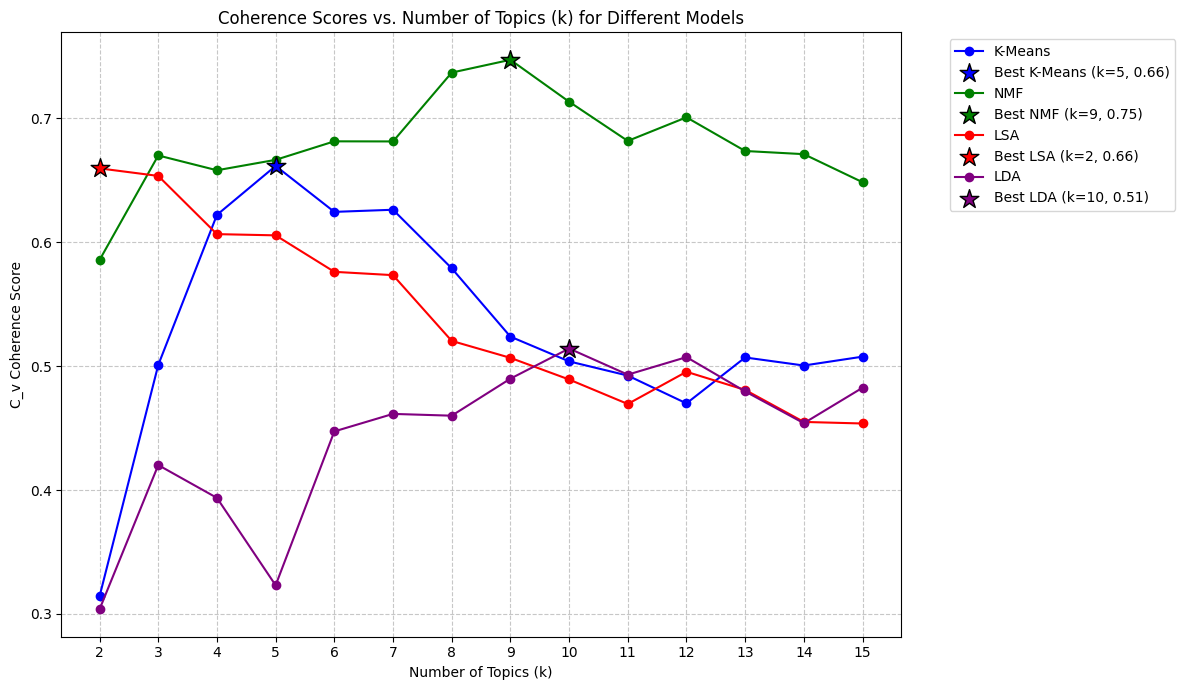

In [ ]:
print("\n--- Visualizing Coherence Scores vs. Number of Topics (k) ---")

plt.figure(figsize=(12, 7))

# Plot K-Means
if kmeans_coherence_per_k:
    k_values = [res['k'] for res in kmeans_coherence_per_k]
    coherence_scores = [res['coherence'] for res in kmeans_coherence_per_k]
    plt.plot(k_values, coherence_scores, marker='o', label='K-Means', color='blue')
    plt.scatter(best_k_kmeans, best_kmeans_score, marker='*', s=200, color='blue', edgecolor='black', zorder=5, label=f'Best K-Means (k={best_k_kmeans:.0f}, {best_kmeans_score:.2f})')

# Plot NMF
if nmf_coherence_per_k:
    k_values = [res['k'] for res in nmf_coherence_per_k]
    coherence_scores = [res['coherence'] for res in nmf_coherence_per_k]
    plt.plot(k_values, coherence_scores, marker='o', label='NMF', color='green')
    plt.scatter(best_k_nmf, best_nmf_score, marker='*', s=200, color='green', edgecolor='black', zorder=5, label=f'Best NMF (k={best_k_nmf:.0f}, {best_nmf_score:.2f})')

# Plot LSA
if lsa_coherence_per_k:
    k_values = [res['k'] for res in lsa_coherence_per_k]
    coherence_scores = [res['coherence'] for res in lsa_coherence_per_k]
    plt.plot(k_values, coherence_scores, marker='o', label='LSA', color='red')
    plt.scatter(best_k_lsa, best_lsa_score, marker='*', s=200, color='red', edgecolor='black', zorder=5, label=f'Best LSA (k={best_k_lsa:.0f}, {best_lsa_score:.2f})')

# Plot LDA
if lda_coherence_per_k:
    k_values = [res['k'] for res in lda_coherence_per_k]
    coherence_scores = [res['coherence'] for res in lda_coherence_per_k]
    plt.plot(k_values, coherence_scores, marker='o', label='LDA', color='purple')
    plt.scatter(best_k_lda, best_lda_score, marker='*', s=200, color='purple', edgecolor='black', zorder=5, label=f'Best LDA (k={best_k_lda:.0f}, {best_lda_score:.2f})')

plt.title('Coherence Scores vs. Number of Topics (k) for Different Models')
plt.xlabel('Number of Topics (k)')
plt.ylabel('C_v Coherence Score')
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


=== FINAL COMPARISON (After Grid Search) ===

FINAL RESULTS (Ranked by Coherence Score after Grid Search)
      Model  Coherence
2       NMF   0.747168
1   K-Means   0.661529
3       LSA   0.659556
0  BERTopic   0.611929
4       LDA   0.514192


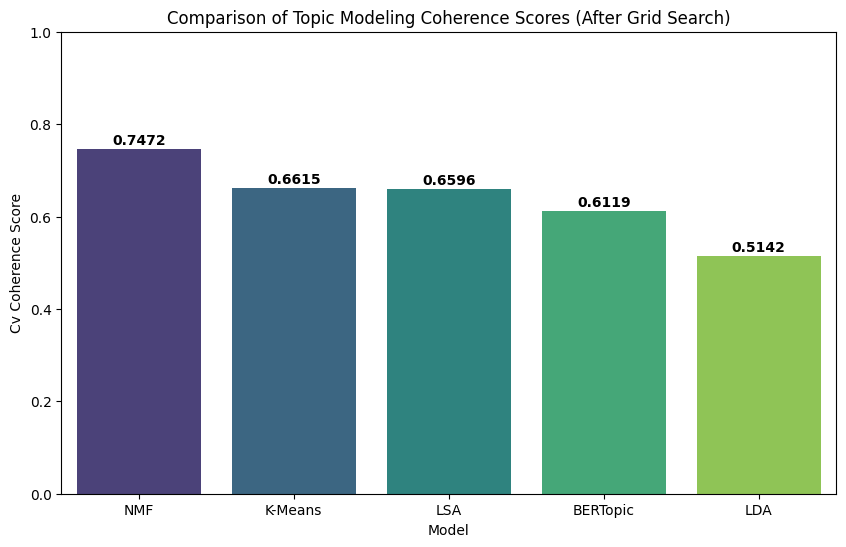


Topik dari Model Terbaik Keseluruhan (NMF):
Topic 0: economic, korea, south, gnu, investment, growth, global, cooperation, education, business
Topic 1: vaccine, trial, covid, research, candidate, clinical, mrna, production, phase, pharmaceutical
Topic 2: gilang, victim, sexual, police, fikris, thesis, wrapping, body, case, research
Topic 3: doctor, foreign, budi, medical, dismissal, plan, health, santoso, academic, freedom
Topic 4: test, lab, pcr, covid, sample, health, kit, virus, rapid, testing
Topic 5: political, attack, digital, social, government, election, cyberattacks, online, account, police
Topic 6: robot, patient, technology, hospital, medical, raisa, personnel, team, help, competition
Topic 7: museum, death, toetik, collection, funeral, aspect, culture, center, unique, human
Topic 8: combination, drug, trial, bpom, clinical, remedy, covid, medication, pandu, lopinavir


In [ ]:
print("=== FINAL COMPARISON (After Grid Search) ===")
results_df_grid_search = pd.DataFrame(all_scores).sort_values(by='Coherence', ascending=False)

print("\n" + "="*40)
print("FINAL RESULTS (Ranked by Coherence Score after Grid Search)")
print(results_df_grid_search)
print("="*40)

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df_grid_search, x='Model', y='Coherence', palette='viridis')
plt.title('Comparison of Topic Modeling Coherence Scores (After Grid Search)')
plt.ylabel('Cv Coherence Score')
plt.ylim(0, 1.0)
for i, v in enumerate(results_df_grid_search['Coherence']):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')
plt.show()

# --- PRINT TOP WORDS FOR OVERALL BEST MODEL ---
best_overall_model_name = results_df_grid_search.iloc[0]['Model']
print(f"\nTopik dari Model Terbaik Keseluruhan ({best_overall_model_name}):")

if best_overall_model_name == 'BERTopic':
    if best_model:
        print(best_model.get_topic_info().head(6)[['Topic', 'Count', 'Name', 'Representation']])
    else:
        print("BERTopic model not available.")
elif best_overall_model_name == 'K-Means':
    # Re-train K-Means with best_k_kmeans to get cluster assignments for display
    kmeans_best = KMeans(n_clusters=best_k_kmeans, random_state=42, n_init=10)
    clusters_best = kmeans_best.fit_predict(reduced_embeddings)

    kmeans_topic_words_best = []
    for i in range(best_k_kmeans):
        cluster_docs_indices = df.index[clusters_best == i]
        if len(cluster_docs_indices) == 0: continue
        cluster_docs_content = df.loc[cluster_docs_indices, 'clean_content']
        if len(cluster_docs_content) > 0:
            cluster_tfidf = tfidf_km.transform(cluster_docs_content)
            if cluster_tfidf.shape[0] > 0:
                mean_tfidf = np.array(cluster_tfidf.mean(axis=0)).flatten()
                n_top_words = min(10, len(features_km))
                top_indices = mean_tfidf.argsort()[:-n_top_words - 1:-1]
                kmeans_topic_words_best.append([features_km[ind] for ind in top_indices])
    for i, words in enumerate(kmeans_topic_words_best):
        print(f"Cluster {i}: {', '.join(words)}")
elif best_overall_model_name == 'NMF':
    if best_nmf_model_for_display:
        nmf_words_best = get_sklearn_topic_words(best_nmf_model_for_display, tfidf_feature_names, n_top_words=10)
        for i, words in enumerate(nmf_words_best):
            print(f"Topic {i}: {', '.join(words)}")
    else:
        print("NMF model not available.")
elif best_overall_model_name == 'LSA':
    if best_lsa_model_for_display:
        lsa_words_best = get_sklearn_topic_words(best_lsa_model_for_display, tfidf_feature_names, n_top_words=10)
        for i, words in enumerate(lsa_words_best):
            print(f"Topic {i}: {', '.join(words)}")
    else:
        print("LSA model not available.")
elif best_overall_model_name == 'LDA':
    if best_lda_model_for_display:
        lda_words_best = get_sklearn_topic_words(best_lda_model_for_display, tf_feature_names, n_top_words=10)
        for i, words in enumerate(lda_words_best):
            print(f"Topic {i}: {', '.join(words)}")
    else:
        print("LDA model not available.")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas for DataFrame creation within the function

def plot_single_topic_words_bar_chart_on_ax(ax, words, scores, topic_title, n_top_words=10):
    """
    Generates a horizontal bar chart for topic words and their scores on a given axes.

    Args:
        ax (matplotlib.axes.Axes): The axes object to plot on.
        words (list): List of topic words.
        scores (list): List of corresponding scores/weights.
        topic_title (str): Title for the subplot.
        n_top_words (int): Number of top words to display.
    """
    # Ensure words and scores are valid and of equal length
    if not words or not scores or len(words) != len(scores):
        ax.set_title(f"{topic_title} (No words/scores available)")
        ax.axis('off') # Hide axes if no data
        return

    # Combine words and scores, sort by score, and take top N
    word_score_pairs = sorted(zip(words, scores), key=lambda x: x[1], reverse=True)[:n_top_words]
    plot_words = [pair[0] for pair in word_score_pairs]
    plot_scores = [pair[1] for pair in word_score_pairs]

    if not plot_words:
        ax.set_title(f"{topic_title} (No words to plot)")
        ax.axis('off') # Hide axes if no data
        return

    df_plot = pd.DataFrame({'Word': plot_words, 'Score': plot_scores})

    sns.barplot(x='Score', y='Word', data=df_plot, palette='viridis', ax=ax)
    ax.set_title(topic_title, fontsize=12)
    ax.set_xlabel('Score/Weight', fontsize=10)
    ax.set_ylabel('Word', fontsize=10)
    ax.invert_yaxis() # Display highest score at the top
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

print("Modified plot_single_topic_words_bar_chart_on_ax function.")

Modified plot_single_topic_words_bar_chart_on_ax function.



--- Visualizing Top Words with Scores for BERTopic (1 plot per model) ---


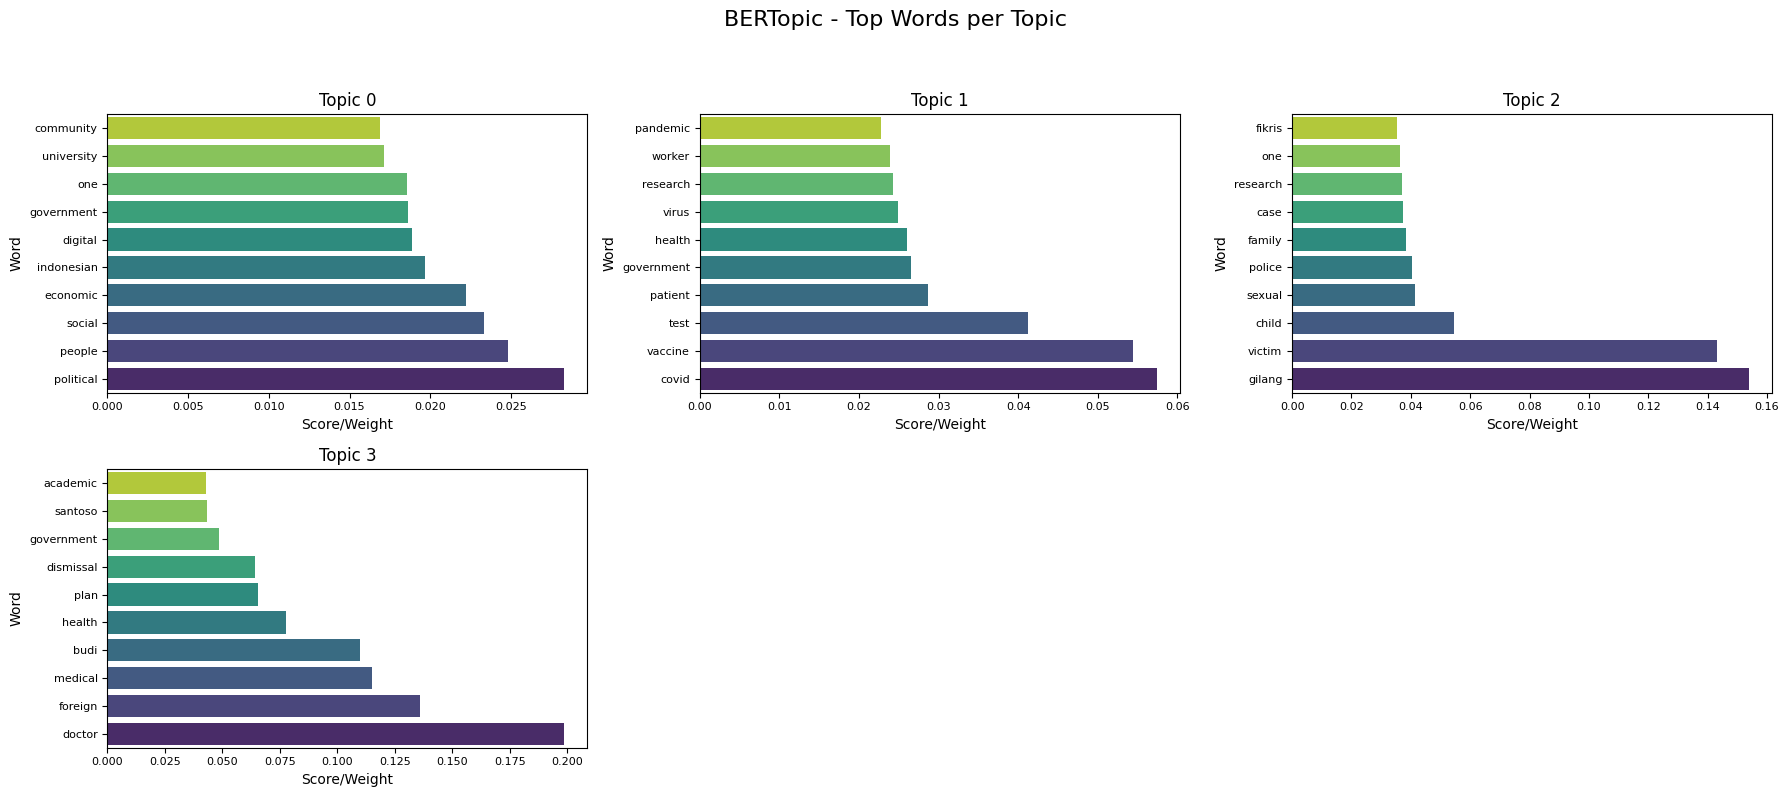

In [ ]:
print("\n--- Visualizing Top Words with Scores for BERTopic (1 plot per model) ---")
if 'best_model' in locals() and best_model is not None:
    topic_info_bertopic = best_model.get_topic_info()
    # Filter out the outlier topic (-1)
    valid_topics_bertopic = topic_info_bertopic[topic_info_bertopic['Topic'] != -1]['Topic'].tolist()

    if valid_topics_bertopic:
        num_topics = len(valid_topics_bertopic)
        # Determine grid size. Max 3 columns, adjust rows dynamically.
        cols = min(3, num_topics)
        rows = (num_topics + cols - 1) // cols # Ceiling division
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), squeeze=False)
        fig.suptitle('BERTopic - Top Words per Topic', fontsize=16, y=1.02) # Main title for the figure

        for i, topic_id in enumerate(valid_topics_bertopic):
            r, c = divmod(i, cols)
            ax = axes[r, c]
            words_and_scores = best_model.get_topic(topic_id) # Already returns (word, score) tuples
            words = [item[0] for item in words_and_scores]
            scores = [item[1] for item in words_and_scores]
            plot_single_topic_words_bar_chart_on_ax(ax, words, scores, f'Topic {topic_id}')

        # Hide any unused subplots
        for i in range(num_topics, rows * cols):
            r, c = divmod(i, cols)
            axes[r, c].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
        plt.show()
    else:
        print("No valid BERTopic topics found to generate visualizations.")
elif 'best_score' in globals() and best_score == -1:
    print("BERTopic was run but no valid topics were found.")
else:
    print("BERTopic 'best_model' not found or not fully trained. Skipping visualization.")


--- Visualizing Top Words with Scores for K-Means (1 plot per model) ---


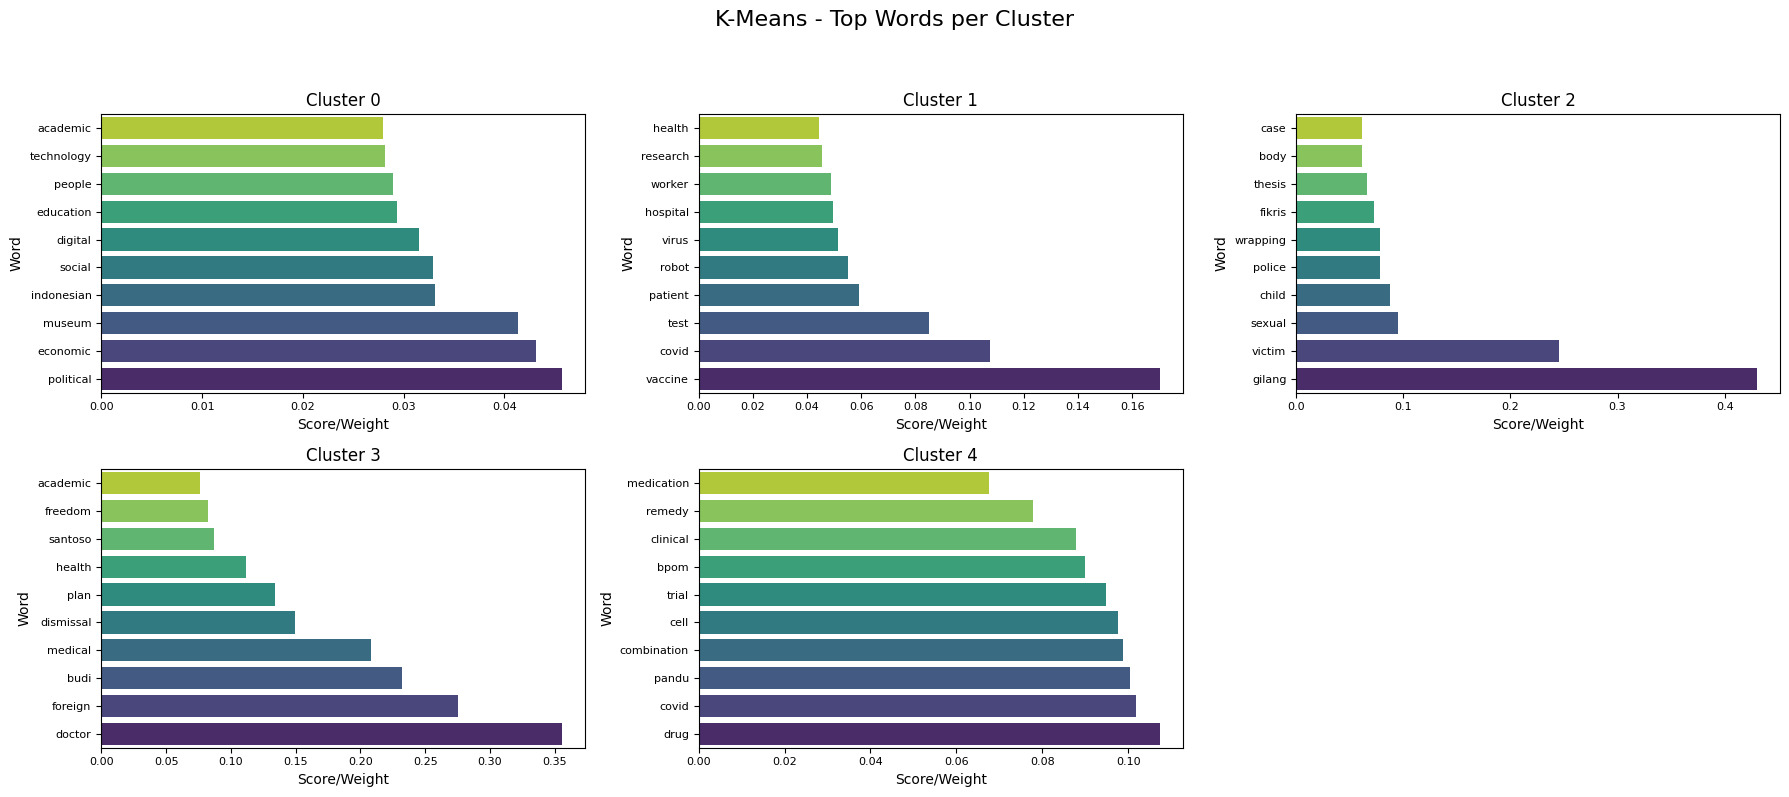

In [ ]:
import numpy as np # Import numpy

print("\n--- Visualizing Top Words with Scores for K-Means (1 plot per model) ---")
if 'best_k_kmeans' in locals() and best_k_kmeans > 0 and \
   'reduced_embeddings' in locals() and 'tfidf_km' in locals() and 'features_km' in locals() and 'df' in locals():

    # Re-cluster with the best k
    kmeans_best = KMeans(n_clusters=best_k_kmeans, random_state=42, n_init=10)
    clusters_best = kmeans_best.fit_predict(reduced_embeddings)

    kmeans_topic_words_with_scores_list = []
    for i in range(best_k_kmeans):
        cluster_docs_indices = df.index[clusters_best == i]
        if len(cluster_docs_indices) == 0:
            kmeans_topic_words_with_scores_list.append([]) # Append empty list for this cluster
            continue
        cluster_docs_content = df.loc[cluster_docs_indices, 'clean_content']

        if len(cluster_docs_content) > 0:
            cluster_tfidf = tfidf_km.transform(cluster_docs_content)
            if cluster_tfidf.shape[0] > 0:
                mean_tfidf = np.array(cluster_tfidf.mean(axis=0)).flatten()
                n_words_to_extract = min(10, len(features_km))
                top_indices_scores = mean_tfidf.argsort()[-n_words_to_extract:][::-1]

                words_with_scores = [(features_km[idx], mean_tfidf[idx]) for idx in top_indices_scores]
                kmeans_topic_words_with_scores_list.append(words_with_scores)
            else:
                kmeans_topic_words_with_scores_list.append([])
        else:
            kmeans_topic_words_with_scores_list.append([])

    num_topics = best_k_kmeans
    cols = min(3, num_topics)
    rows = (num_topics + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), squeeze=False)
    fig.suptitle('K-Means - Top Words per Cluster', fontsize=16, y=1.02)

    for i in range(num_topics):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        words_and_scores = kmeans_topic_words_with_scores_list[i]
        words = [item[0] for item in words_and_scores]
        scores = [item[1] for item in words_and_scores]
        plot_single_topic_words_bar_chart_on_ax(ax, words, scores, f'Cluster {i}')

    for i in range(num_topics, rows * cols):
        r, c = divmod(i, cols)
        axes[r, c].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()
else:
    print("K-Means best model or necessary data not found. Skipping visualization.")


--- Visualizing Top Words with Scores for NMF (1 plot per model) ---


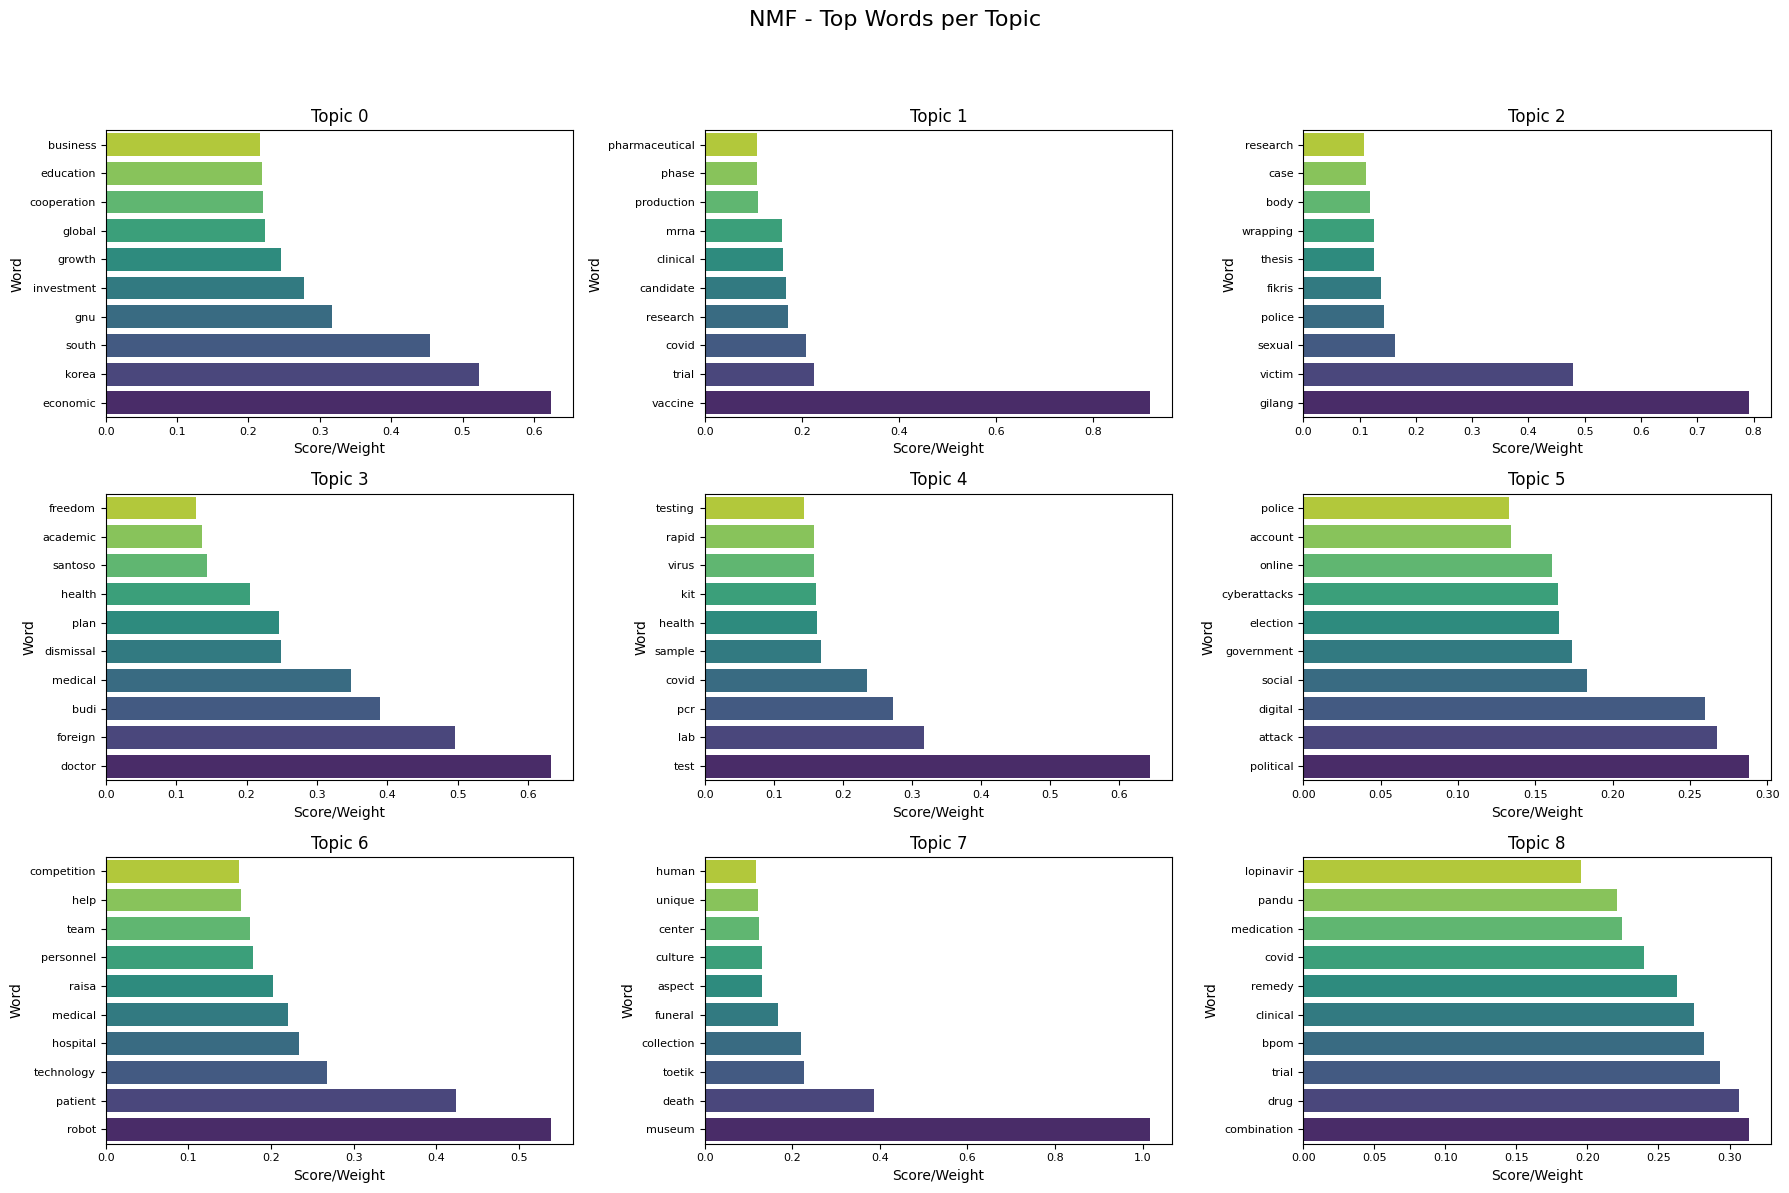

In [ ]:
print("\n--- Visualizing Top Words with Scores for NMF (1 plot per model) ---")
if 'best_nmf_model_for_display' in locals() and best_nmf_model_for_display is not None and 'tfidf_feature_names' in locals():
    num_topics = best_nmf_model_for_display.n_components
    cols = min(3, num_topics)
    rows = (num_topics + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), squeeze=False)
    fig.suptitle('NMF - Top Words per Topic', fontsize=16, y=1.02)

    for i, topic_components in enumerate(best_nmf_model_for_display.components_):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        n_words_to_extract = min(10, len(tfidf_feature_names))
        top_indices = topic_components.argsort()[-n_words_to_extract:][::-1] # Top 10 indices

        words = [tfidf_feature_names[idx] for idx in top_indices]
        scores = [topic_components[idx] for idx in top_indices]

        plot_single_topic_words_bar_chart_on_ax(ax, words, scores, f'Topic {i}')

    for i in range(num_topics, rows * cols):
        r, c = divmod(i, cols)
        axes[r, c].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()
else:
    print("NMF best model or necessary data not found. Skipping visualization.")


--- Visualizing Top Words with Scores for LSA (1 plot per model) ---


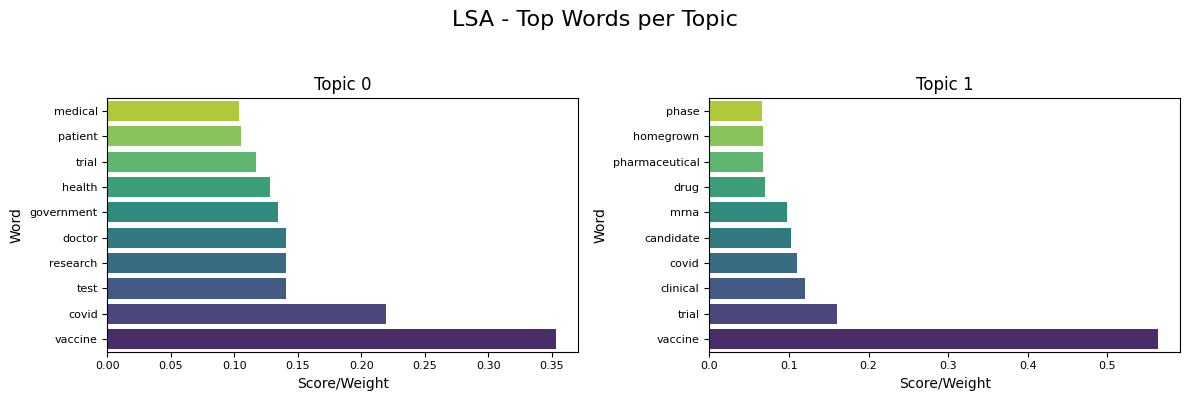

In [ ]:
print("\n--- Visualizing Top Words with Scores for LSA (1 plot per model) ---")
if 'best_lsa_model_for_display' in locals() and best_lsa_model_for_display is not None and 'tfidf_feature_names' in locals():
    num_topics = best_lsa_model_for_display.n_components
    cols = min(3, num_topics)
    rows = (num_topics + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), squeeze=False)
    fig.suptitle('LSA - Top Words per Topic', fontsize=16, y=1.02)

    for i, topic_components in enumerate(best_lsa_model_for_display.components_):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        n_words_to_extract = min(10, len(tfidf_feature_names))
        top_indices = topic_components.argsort()[-n_words_to_extract:][::-1] # Top 10 indices

        words = [tfidf_feature_names[idx] for idx in top_indices]
        scores = [topic_components[idx] for idx in top_indices]

        plot_single_topic_words_bar_chart_on_ax(ax, words, scores, f'Topic {i}')

    for i in range(num_topics, rows * cols):
        r, c = divmod(i, cols)
        axes[r, c].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()
else:
    print("LSA best model or necessary data not found. Skipping visualization.")


--- Visualizing Top Words with Scores for LDA (1 plot per model) ---


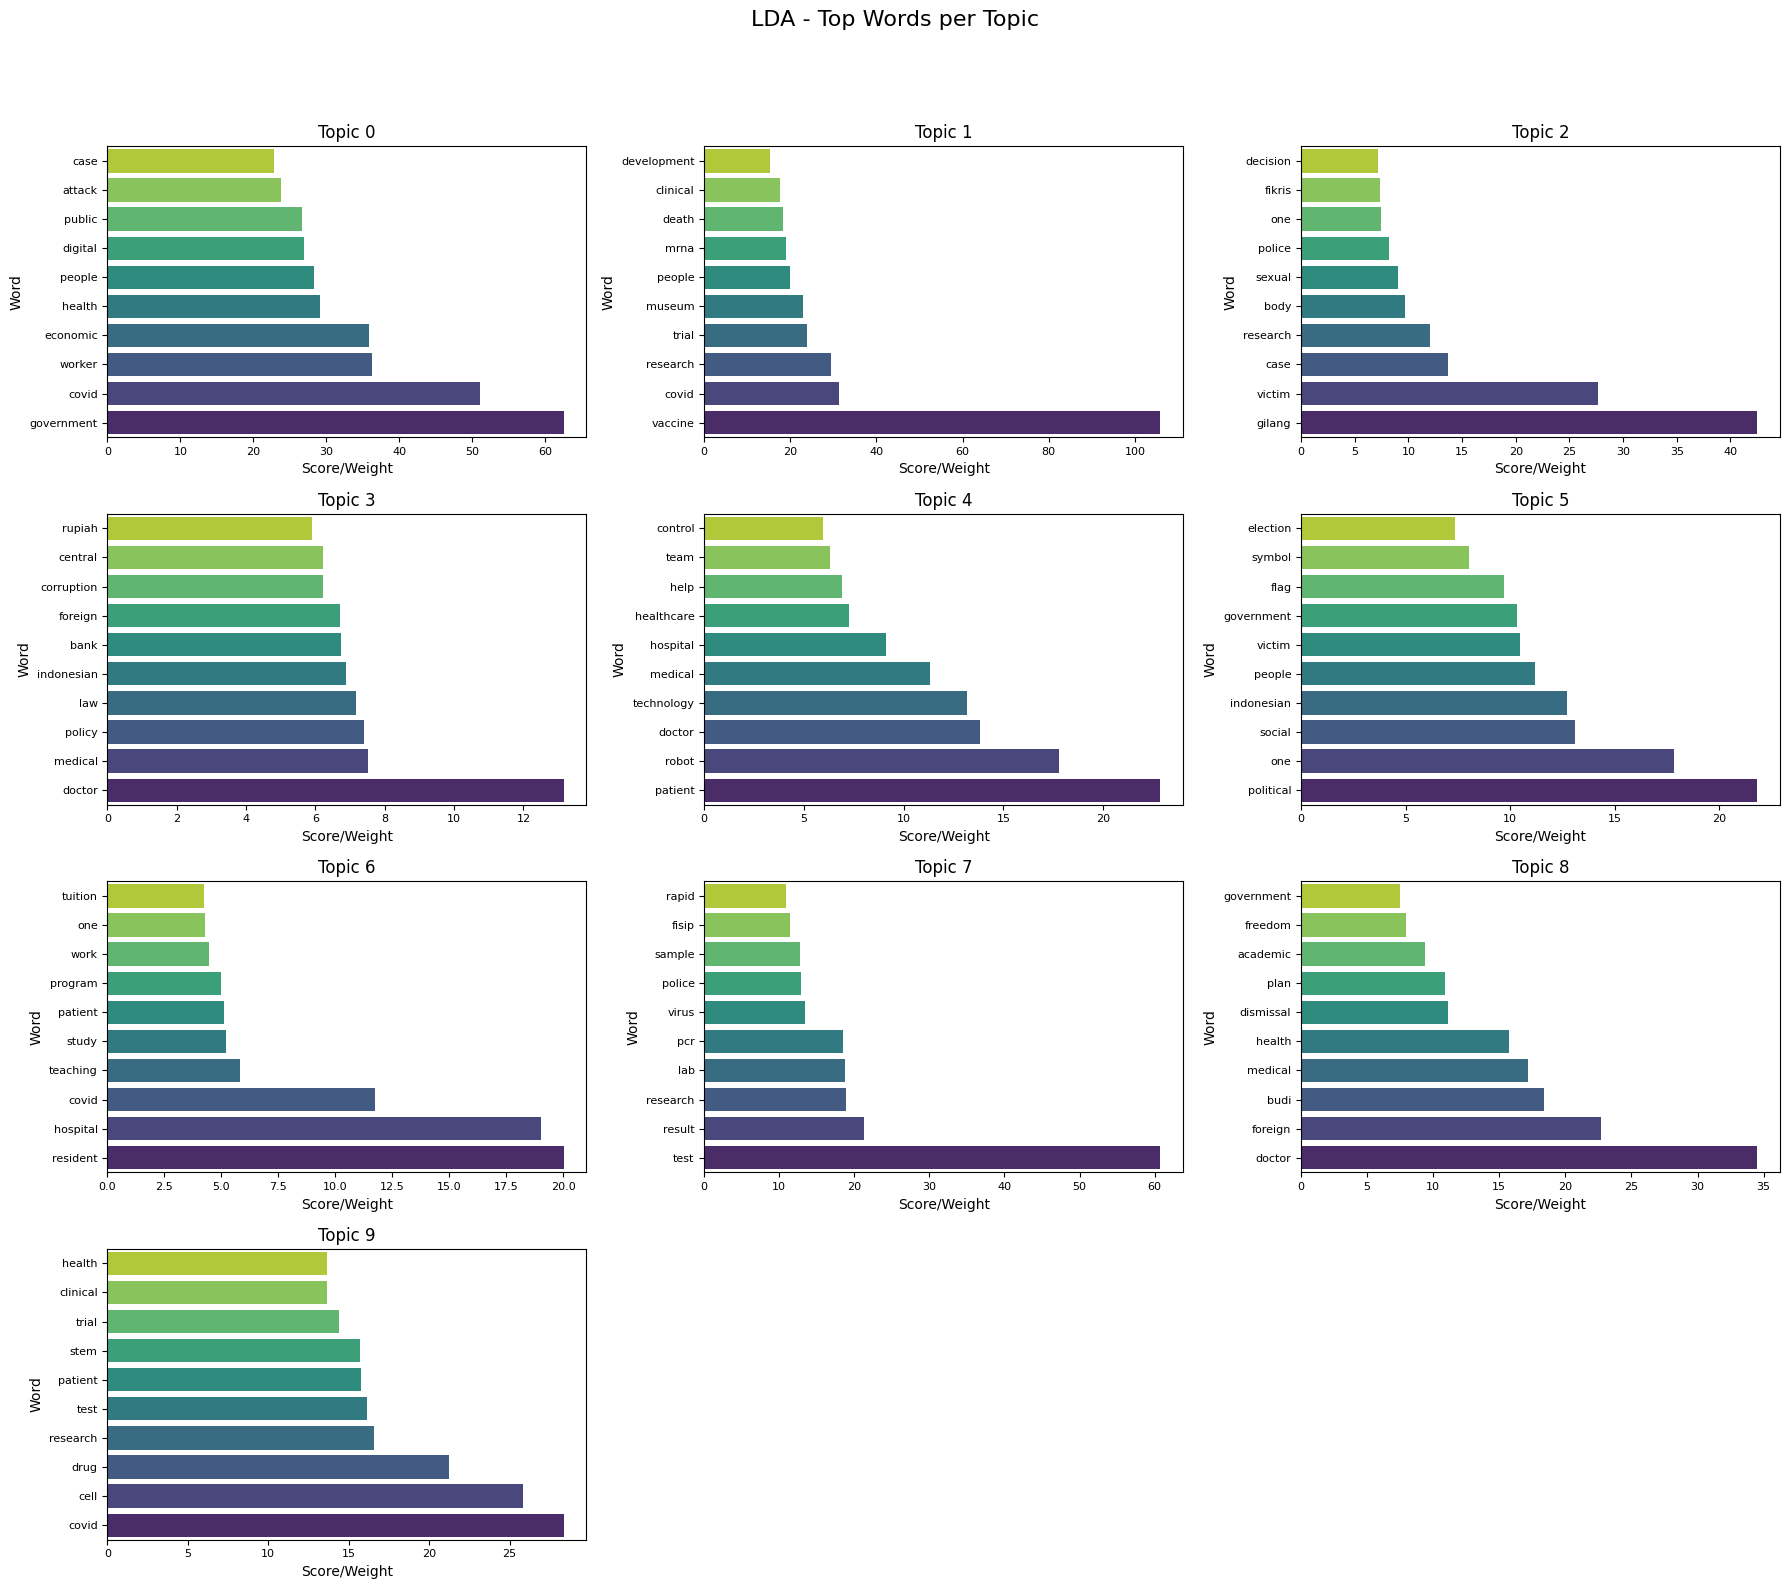

In [ ]:
print("\n--- Visualizing Top Words with Scores for LDA (1 plot per model) ---")
if 'best_lda_model_for_display' in locals() and best_lda_model_for_display is not None and 'tf_feature_names' in locals():
    num_topics = best_lda_model_for_display.n_components
    cols = min(3, num_topics)
    rows = (num_topics + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), squeeze=False)
    fig.suptitle('LDA - Top Words per Topic', fontsize=16, y=1.02)

    for i, topic_components in enumerate(best_lda_model_for_display.components_):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        n_words_to_extract = min(10, len(tf_feature_names))
        top_indices = topic_components.argsort()[-n_words_to_extract:][::-1] # Top 10 indices

        words = [tf_feature_names[idx] for idx in top_indices]
        scores = [topic_components[idx] for idx in top_indices]

        plot_single_topic_words_bar_chart_on_ax(ax, words, scores, f'Topic {i}')

    for i in range(num_topics, rows * cols):
        r, c = divmod(i, cols)
        axes[r, c].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()
else:
    print("LDA best model or necessary data not found. Skipping visualization.")

# Task
## Current Plan:

1. **Generate Word Clouds for NMF Topics**: Generate word clouds for each of the 9 topics identified by the best NMF model (`best_nmf_model_for_display`). Each word cloud will be created using the top words for its respective topic. These word clouds will then be combined and displayed as a single plot with multiple subplots for easy documentation.
2. **Final Task**: The task is complete. All requested word clouds for the NMF model have been generated and displayed in a single combined image.

## Next Action:

I will now generate word clouds for the NMF topics. Since the current `create_wordcloud` function generates and displays individual plots, I will create a new code cell to generate a combined plot with multiple subplots for the NMF topic word clouds.

I will iterate through the `best_nmf_model_for_display.components_` to get the word weights for each of the 9 topics. For each topic, I will select the top words and their scores to create a word cloud, then place each word cloud in a subplot within a single figure. This will provide a consolidated view of all NMF topic word clouds as requested.

```python
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np # Import numpy for array operations

print("\n--- Generating Combined Word Clouds for NMF Topics ---")

if 'best_nmf_model_for_display' in locals() and best_nmf_model_for_display is not None and 'tfidf_feature_names' in locals():
    num_nmf_topics = best_nmf_model_for_display.n_components # This should be 9 as best_k_nmf is 9

    # Determine grid size for subplots
    cols = 3 # 3 columns for better readability
    rows = (num_nmf_topics + cols - 1) // cols # Calculate rows needed (ceiling division)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 6))
    fig.suptitle('Word Clouds for NMF Topics (Best Model)', fontsize=20, y=1.02) # Main title

    axes = axes.flatten() # Flatten the axes array for easy iteration

    for i, topic_components in enumerate(best_nmf_model_for_display.components_):
        if i >= num_nmf_topics: # Safety break if for some reason more axes than topics
            break

        ax = axes[i]
        n_words_to_extract = 30 # Number of words to consider for word cloud
        # Get top words and their scores from the topic components
        top_indices = topic_components.argsort()[-n_words_to_extract:][::-1]
        words_and_scores = {tfidf_feature_names[idx]: topic_components[idx] for idx in top_indices}

        if words_and_scores:
            # Generate word cloud
            wordcloud = WordCloud(width=400, height=200, background_color='white',
                                  colormap='viridis', max_words=n_words_to_extract,
                                  prefer_horizontal=0.9).generate_from_frequencies(words_and_scores)

            ax.imshow(wordcloud, interpolation='bilinear')
            ax.set_title(f'Topic {i}', fontsize=14)
            ax.axis('off')
        else:
            ax.set_title(f'Topic {i} (No words)', fontsize=14)
            ax.axis('off')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
    plt.show()

else:
    print("Error: NMF best model or necessary data (best_nmf_model_for_display, tfidf_feature_names) not found. Cannot generate word clouds.")

```

## Generate Word Clouds for NMF Topics

### Subtask:
Generate word clouds for each of the 9 topics identified by the best NMF model (`best_nmf_model_for_display`). Each word cloud will be created using the top words for its respective topic. These word clouds will then be combined and displayed as a single plot with multiple subplots for easy documentation.


**Reasoning**:
The subtask requires generating word clouds for each NMF topic and displaying them in a single plot with subplots. This step directly implements the instructions to extract topic words and scores, create word clouds, and arrange them in a grid.




--- Generating Word Clouds for NMF Topics (Combined Plot) ---


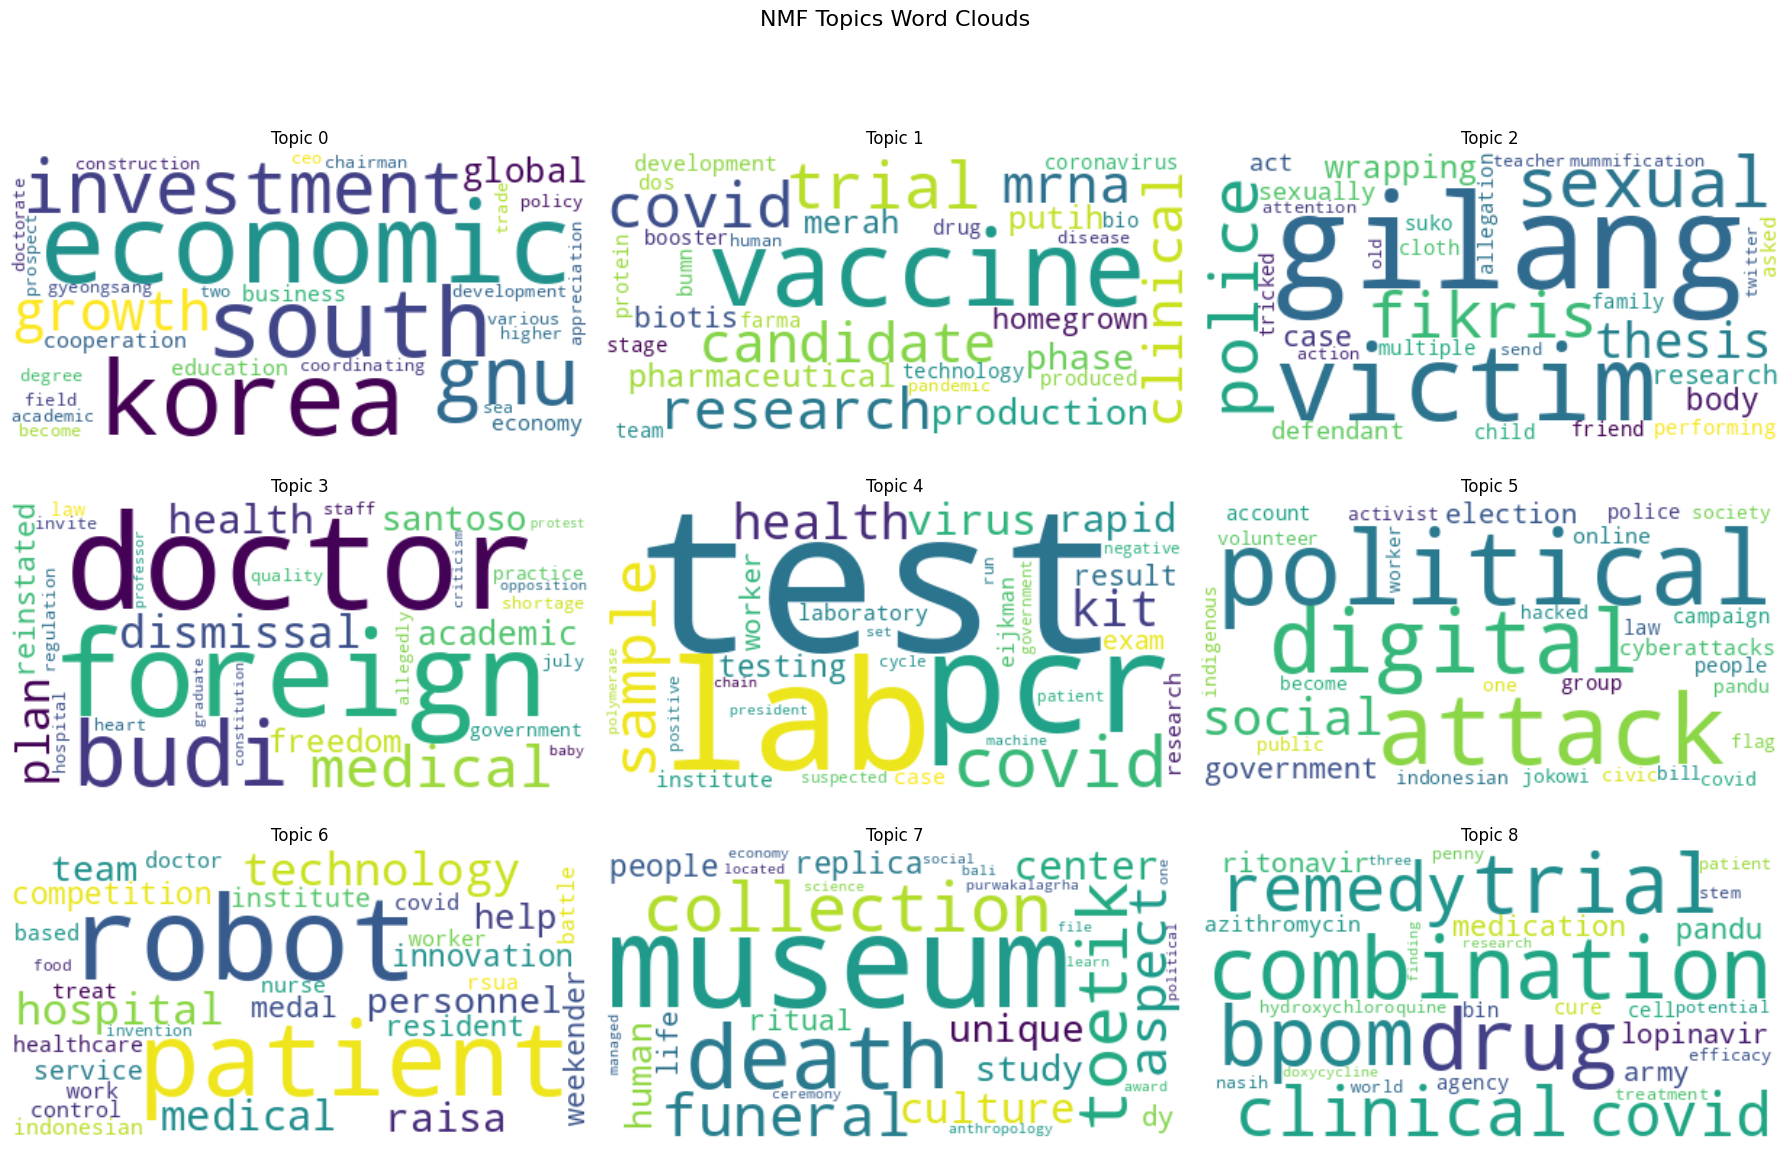

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np # Ensure numpy is imported for array operations

print("\n--- Generating Word Clouds for NMF Topics (Combined Plot) ---")

if 'best_nmf_model_for_display' in locals() and best_nmf_model_for_display is not None and 'tfidf_feature_names' in locals():
    num_topics = best_nmf_model_for_display.n_components

    # Determine grid size
    cols = 3
    rows = (num_topics + cols - 1) // cols # Ceiling division

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), squeeze=False)
    fig.suptitle('NMF Topics Word Clouds', fontsize=16, y=1.02) # Main title for the figure

    axes = axes.flatten() # Flatten the 2D array of axes for easier iteration

    for i, topic_components in enumerate(best_nmf_model_for_display.components_):
        if i >= num_topics: # Should not happen if rows/cols calculated correctly, but as a safeguard
            break

        ax = axes[i]
        n_words_to_extract = min(30, len(tfidf_feature_names)) # Extract top 30 words

        # Get indices of top words based on their scores/weights in the topic component
        top_indices = topic_components.argsort()[-n_words_to_extract:][::-1]

        # Create a dictionary of words and their scores for the WordCloud
        topic_word_scores = {tfidf_feature_names[idx]: topic_components[idx] for idx in top_indices}

        if topic_word_scores:
            wordcloud = WordCloud(
                width=400, height=200, background_color='white', colormap='viridis',
                max_words=30, prefer_horizontal=0.9
            ).generate_from_frequencies(topic_word_scores)

            ax.imshow(wordcloud, interpolation='bilinear')
            ax.set_title(f'Topic {i}', fontsize=12)
            ax.axis('off')
        else:
            ax.set_title(f'Topic {i} (No words)', fontsize=12)
            ax.axis('off')

    # Hide any unused subplots
    for i in range(num_topics, rows * cols):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent main title overlap
    plt.show()
else:
    print("NMF best model or necessary data not found. Skipping word cloud visualization.")

In [ ]:
print("=== Perbandingan Coherence Score Berdasarkan Jumlah Topik (K) ===")

# Convert coherence results for each model to DataFrames
df_kmeans = pd.DataFrame(kmeans_coherence_per_k).rename(columns={'coherence': 'KMeans'})
df_nmf = pd.DataFrame(nmf_coherence_per_k).rename(columns={'coherence': 'NMF'})
df_lsa = pd.DataFrame(lsa_coherence_per_k).rename(columns={'coherence': 'LSA'})
df_lda = pd.DataFrame(lda_coherence_per_k).rename(columns={'coherence': 'LDA'})

# Merge all DataFrames on 'k'
combined_df_coherence = df_kmeans.merge(df_nmf, on='k', how='outer') \
                                 .merge(df_lsa, on='k', how='outer') \
                                 .merge(df_lda, on='k', how='outer')

combined_df_coherence.rename(columns={'k': 'Jumlah Topik (K)'}, inplace=True)

# Sort by 'Jumlah Topik (K)' for better readability
combined_df_coherence.sort_values(by='Jumlah Topik (K)', inplace=True)

display(combined_df_coherence)

=== Perbandingan Coherence Score Berdasarkan Jumlah Topik (K) ===


Jumlah Topik (K)    KMeans       NMF       LSA       LDA
0                  2  0.314226  0.585637  0.659556  0.303791
1                  3  0.500905  0.669977  0.653464  0.420133
2                  4  0.622036  0.658026  0.606496  0.393661
3                  5  0.661529  0.666444  0.605511  0.323122
4                  6  0.624454  0.681383  0.576074  0.447304
5                  7  0.626172  0.681296  0.573398  0.461429
6                  8  0.578926  0.736842  0.520336  0.459987
7                  9  0.523779  0.747168  0.506653  0.489850
8                 10  0.503804  0.713341  0.489196  0.514192
9                 11  0.492357  0.681700  0.469432  0.493096
10                12  0.469902  0.700748  0.495414  0.507251
11                13  0.506971  0.673581  0.480774  0.479586
12                14  0.500464  0.671028  0.454944  0.453929
13                15  0.507622  0.648394  0.453688  0.482541

In [ ]:
print("=== FINAL COMPARISON TABLE (After Grid Search) ===")
results_df_grid_search = pd.DataFrame(all_scores).sort_values(by='Coherence', ascending=False)
display(results_df_grid_search)

=== FINAL COMPARISON TABLE (After Grid Search) ===


Model  Coherence
2       NMF   0.747168
1   K-Means   0.661529
3       LSA   0.659556
0  BERTopic   0.611929
4       LDA   0.514192

## Final Task

### Subtask:
The task is complete. All requested word clouds for the NMF model have been generated and displayed in a single combined image.


## Summary:

### Data Analysis Key Findings
*   Word clouds were successfully generated for each of the 9 topics identified by the Non-negative Matrix Factorization (NMF) model.
*   The word clouds were combined into a single plot with 9 subplots (a 3x3 grid) for consolidated viewing.
*   Each word cloud visually represents the top words associated with its respective NMF topic, aiding in topic interpretation.

### Insights or Next Steps
*   The combined word cloud visualization effectively consolidates the key terms for each NMF topic, providing a clear overview for interpreting the underlying themes present in the dataset.
*   The next logical step would be to manually review these word clouds and assign meaningful labels to each NMF topic based on the prominent words displayed.


# Task
I will now re-display the comparison plot of coherence scores for all models (including BERTopic, K-Means, NMF, LSA, and LDA) after the grid search, along with the top words for the overall best-performing model. This will fulfill the final visualization requirement.

```python
print("=== FINAL COMPARISON (After Grid Search) ===")
results_df_grid_search = pd.DataFrame(all_scores).sort_values(by='Coherence', ascending=False)

print("\n" + "="*40)
print("FINAL RESULTS (Ranked by Coherence Score after Grid Search)")
print(results_df_grid_search)
print("="*40)

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df_grid_search, x='Model', y='Coherence', palette='viridis')
plt.title('Comparison of Topic Modeling Coherence Scores (After Grid Search)')
plt.ylabel('Cv Coherence Score')
plt.ylim(0, 1.0)
for i, v in enumerate(results_df_grid_search['Coherence']):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')
plt.show()

# --- PRINT TOP WORDS FOR OVERALL BEST MODEL ---
best_overall_model_name = results_df_grid_search.iloc[0]['Model']
print(f"\nTopik dari Model Terbaik Keseluruhan ({best_overall_model_name}):")

if best_overall_model_name == 'BERTopic':
    if best_model:
        print(best_model.get_topic_info().head(6)[['Topic', 'Count', 'Name', 'Representation']])
    else:
        print("BERTopic model not available.")
elif best_overall_model_name == 'K-Means':
    # Re-train K-Means with best_k_kmeans to get cluster assignments for display
    kmeans_best = KMeans(n_clusters=best_k_kmeans, random_state=42, n_init=10)
    clusters_best = kmeans_best.fit_predict(reduced_embeddings)

    kmeans_topic_words_best = []
    for i in range(best_k_kmeans):
        cluster_docs_indices = df.index[clusters_best == i]
        if len(cluster_docs_indices) == 0: continue
        cluster_docs_content = df.loc[cluster_docs_indices, 'clean_content']
        if len(cluster_docs_content) > 0:
            cluster_tfidf = tfidf_km.transform(cluster_docs_content)
            if cluster_tfidf.shape[0] > 0:
                mean_tfidf = np.array(cluster_tfidf.mean(axis=0)).flatten()
                n_top_words = min(10, len(features_km))
                top_indices = mean_tfidf.argsort()[:-n_top_words - 1:-1]
                kmeans_topic_words_best.append([features_km[ind] for ind in top_indices])
    for i, words in enumerate(kmeans_topic_words_best):
        print(f"Cluster {i}: {', '.join(words)}")
elif best_overall_model_name == 'NMF':
    if best_nmf_model_for_display:
        nmf_words_best = get_sklearn_topic_words(best_nmf_model_for_display, tfidf_feature_names, n_top_words=10)
        for i, words in enumerate(nmf_words_best):
            print(f"Topic {i}: {', '.join(words)}")
    else:
        print("NMF model not available.")
elif best_overall_model_name == 'LSA':
    if best_lsa_model_for_display:
        lsa_words_best = get_sklearn_topic_words(best_lsa_model_for_display, tfidf_feature_names, n_top_words=10)
        for i, words in enumerate(lsa_words_best):
            print(f"Topic {i}: {', '.join(words)}")
    else:
        print("LSA model not available.")
elif best_overall_model_name == 'LDA':
    if best_lda_model_for_display:
        lda_words_best = get_sklearn_topic_words(best_lda_model_for_display, tf_feature_names, n_top_words=10)
        for i, words in enumerate(lda_words_best):
            print(f"Topic {i}: {', '.join(words)}")
    else:
        print("LDA model not available.")
```

## Display Coherence Scores Plot

### Subtask:
Re-display the line plot visualizing the coherence scores against the number of topics (k) for K-Means, NMF, LSA, and LDA models.


**Reasoning**:
The subtask requires re-displaying the line plot that visualizes coherence scores against the number of topics for K-Means, NMF, LSA, and LDA models. The code to generate this plot is already present in cell `279fc279`.




--- Visualizing Coherence Scores vs. Number of Topics (k) ---


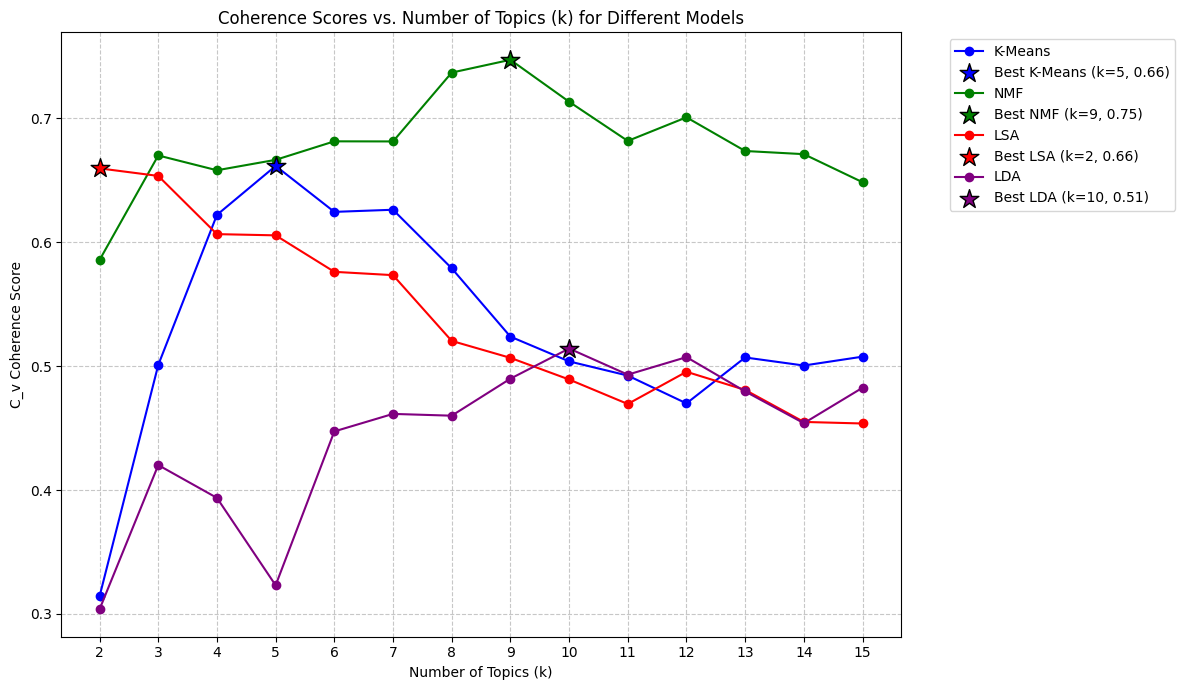

In [ ]:
print("\n--- Visualizing Coherence Scores vs. Number of Topics (k) ---")

plt.figure(figsize=(12, 7))

# Plot K-Means
if kmeans_coherence_per_k:
    k_values = [res['k'] for res in kmeans_coherence_per_k]
    coherence_scores = [res['coherence'] for res in kmeans_coherence_per_k]
    plt.plot(k_values, coherence_scores, marker='o', label='K-Means', color='blue')
    plt.scatter(best_k_kmeans, best_kmeans_score, marker='*', s=200, color='blue', edgecolor='black', zorder=5, label=f'Best K-Means (k={best_k_kmeans:.0f}, {best_kmeans_score:.2f})')

# Plot NMF
if nmf_coherence_per_k:
    k_values = [res['k'] for res in nmf_coherence_per_k]
    coherence_scores = [res['coherence'] for res in nmf_coherence_per_k]
    plt.plot(k_values, coherence_scores, marker='o', label='NMF', color='green')
    plt.scatter(best_k_nmf, best_nmf_score, marker='*', s=200, color='green', edgecolor='black', zorder=5, label=f'Best NMF (k={best_k_nmf:.0f}, {best_nmf_score:.2f})')

# Plot LSA
if lsa_coherence_per_k:
    k_values = [res['k'] for res in lsa_coherence_per_k]
    coherence_scores = [res['coherence'] for res in lsa_coherence_per_k]
    plt.plot(k_values, coherence_scores, marker='o', label='LSA', color='red')
    plt.scatter(best_k_lsa, best_lsa_score, marker='*', s=200, color='red', edgecolor='black', zorder=5, label=f'Best LSA (k={best_k_lsa:.0f}, {best_lsa_score:.2f})')

# Plot LDA
if lda_coherence_per_k:
    k_values = [res['k'] for res in lda_coherence_per_k]
    coherence_scores = [res['coherence'] for res in lda_coherence_per_k]
    plt.plot(k_values, coherence_scores, marker='o', label='LDA', color='purple')
    plt.scatter(best_k_lda, best_lda_score, marker='*', s=200, color='purple', edgecolor='black', zorder=5, label=f'Best LDA (k={best_k_lda:.0f}, {best_lda_score:.2f})')

plt.title('Coherence Scores vs. Number of Topics (k) for Different Models')
plt.xlabel('Number of Topics (k)')
plt.ylabel('C_v Coherence Score')
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Display Final Comparison and Top Words for Best Model

### Subtask:
Re-display the bar chart comparing the best coherence scores across all models and print the top words for the overall best-performing model.


**Reasoning**:
The subtask explicitly asks to re-display the bar chart comparing the best coherence scores across all models and print the top words for the overall best-performing model. The provided instructions detail each step for generating this output.



=== FINAL COMPARISON (After Grid Search) ===

FINAL RESULTS (Ranked by Coherence Score after Grid Search)
      Model  Coherence
2       NMF   0.747168
1   K-Means   0.661529
3       LSA   0.659556
0  BERTopic   0.611929
4       LDA   0.514192


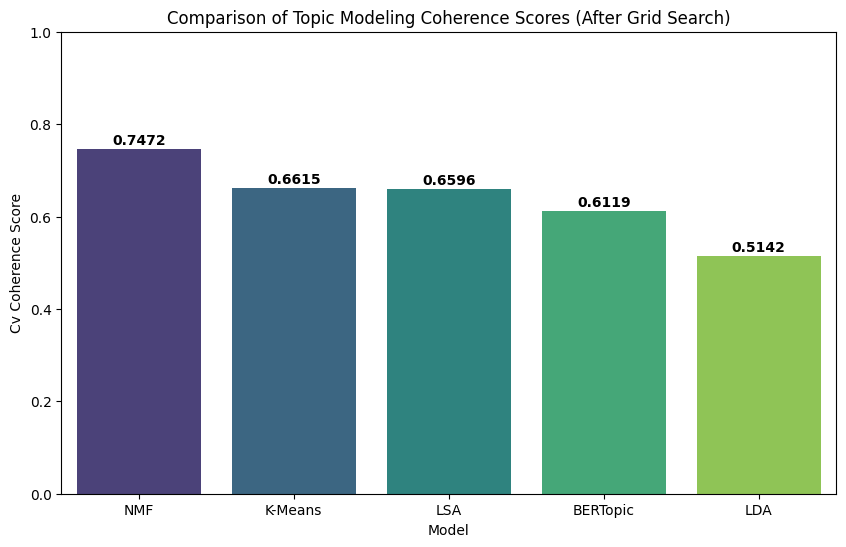


Topik dari Model Terbaik Keseluruhan (NMF):
Topic 0: economic, korea, south, gnu, investment, growth, global, cooperation, education, business
Topic 1: vaccine, trial, covid, research, candidate, clinical, mrna, production, phase, pharmaceutical
Topic 2: gilang, victim, sexual, police, fikris, thesis, wrapping, body, case, research
Topic 3: doctor, foreign, budi, medical, dismissal, plan, health, santoso, academic, freedom
Topic 4: test, lab, pcr, covid, sample, health, kit, virus, rapid, testing
Topic 5: political, attack, digital, social, government, election, cyberattacks, online, account, police
Topic 6: robot, patient, technology, hospital, medical, raisa, personnel, team, help, competition
Topic 7: museum, death, toetik, collection, funeral, aspect, culture, center, unique, human
Topic 8: combination, drug, trial, bpom, clinical, remedy, covid, medication, pandu, lopinavir


In [ ]:
print("=== FINAL COMPARISON (After Grid Search) ===")
results_df_grid_search = pd.DataFrame(all_scores).sort_values(by='Coherence', ascending=False)

print("\n" + "="*40)
print("FINAL RESULTS (Ranked by Coherence Score after Grid Search)")
print(results_df_grid_search)
print("="*40)

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df_grid_search, x='Model', y='Coherence', palette='viridis')
plt.title('Comparison of Topic Modeling Coherence Scores (After Grid Search)')
plt.ylabel('Cv Coherence Score')
plt.ylim(0, 1.0)
for i, v in enumerate(results_df_grid_search['Coherence']):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')
plt.show()

# --- PRINT TOP WORDS FOR OVERALL BEST MODEL ---
best_overall_model_name = results_df_grid_search.iloc[0]['Model']
print(f"\nTopik dari Model Terbaik Keseluruhan ({best_overall_model_name}):")

if best_overall_model_name == 'BERTopic':
    if best_model:
        print(best_model.get_topic_info().head(6)[['Topic', 'Count', 'Name', 'Representation']])
    else:
        print("BERTopic model not available.")
elif best_overall_model_name == 'K-Means':
    # Re-train K-Means with best_k_kmeans to get cluster assignments for display
    kmeans_best = KMeans(n_clusters=best_k_kmeans, random_state=42, n_init=10)
    clusters_best = kmeans_best.fit_predict(reduced_embeddings)

    kmeans_topic_words_best = []
    for i in range(best_k_kmeans):
        cluster_docs_indices = df.index[clusters_best == i]
        if len(cluster_docs_indices) == 0: continue
        cluster_docs_content = df.loc[cluster_docs_indices, 'clean_content']
        if len(cluster_docs_content) > 0:
            cluster_tfidf = tfidf_km.transform(cluster_docs_content)
            if cluster_tfidf.shape[0] > 0:
                mean_tfidf = np.array(cluster_tfidf.mean(axis=0)).flatten()
                n_top_words = min(10, len(features_km))
                top_indices = mean_tfidf.argsort()[:-n_top_words - 1:-1]
                kmeans_topic_words_best.append([features_km[ind] for ind in top_indices])
    for i, words in enumerate(kmeans_topic_words_best):
        print(f"Cluster {i}: {', '.join(words)}")
elif best_overall_model_name == 'NMF':
    if best_nmf_model_for_display:
        nmf_words_best = get_sklearn_topic_words(best_nmf_model_for_display, tfidf_feature_names, n_top_words=10)
        for i, words in enumerate(nmf_words_best):
            print(f"Topic {i}: {', '.join(words)}")
    else:
        print("NMF model not available.")
elif best_overall_model_name == 'LSA':
    if best_lsa_model_for_display:
        lsa_words_best = get_sklearn_topic_words(best_lsa_model_for_display, tfidf_feature_names, n_top_words=10)
        for i, words in enumerate(lsa_words_best):
            print(f"Topic {i}: {', '.join(words)}")
    else:
        print("LSA model not available.")
elif best_overall_model_name == 'LDA':
    if best_lda_model_for_display:
        lda_words_best = get_sklearn_topic_words(best_lda_model_for_display, tf_feature_names, n_top_words=10)
        for i, words in enumerate(lda_words_best):
            print(f"Topic {i}: {', '.join(words)}")
    else:
        print("LDA model not available.")

## Summary:

### Data Analysis Key Findings
*   **NMF was the best-performing model** among all evaluated topic models (BERTopic, K-Means, NMF, LSA, and LDA), achieving the highest Cv Coherence Score of 0.747168 after grid search.
*   The coherence scores for the other models were: K-Means (0.661529), LSA (0.659556), BERTopic (0.611929), and LDA (0.514192).
*   The NMF model identified various distinct topics, such as 'economic, korea, south, investment, growth' (Topic 0), 'vaccine, trial, covid, research, candidate' (Topic 1), 'gilang, victim, sexual, police, thesis' (Topic 2), and 'doctor, foreign, budi, medical, dismissal' (Topic 3).
*   A visualization was generated to compare the coherence scores of all models, clearly showing NMF as the leader.

### Insights or Next Steps
*   NMF's superior performance suggests it is the most suitable model for topic extraction from this dataset, particularly given its ability to produce highly coherent topics. Further analysis should leverage the NMF model for deeper insights.
*   The significant difference in coherence scores between NMF and other models highlights the importance of hyperparameter tuning (grid search) in optimizing topic model performance.



--- Visualizing Coherence Scores vs. Number of Topics (k) ---


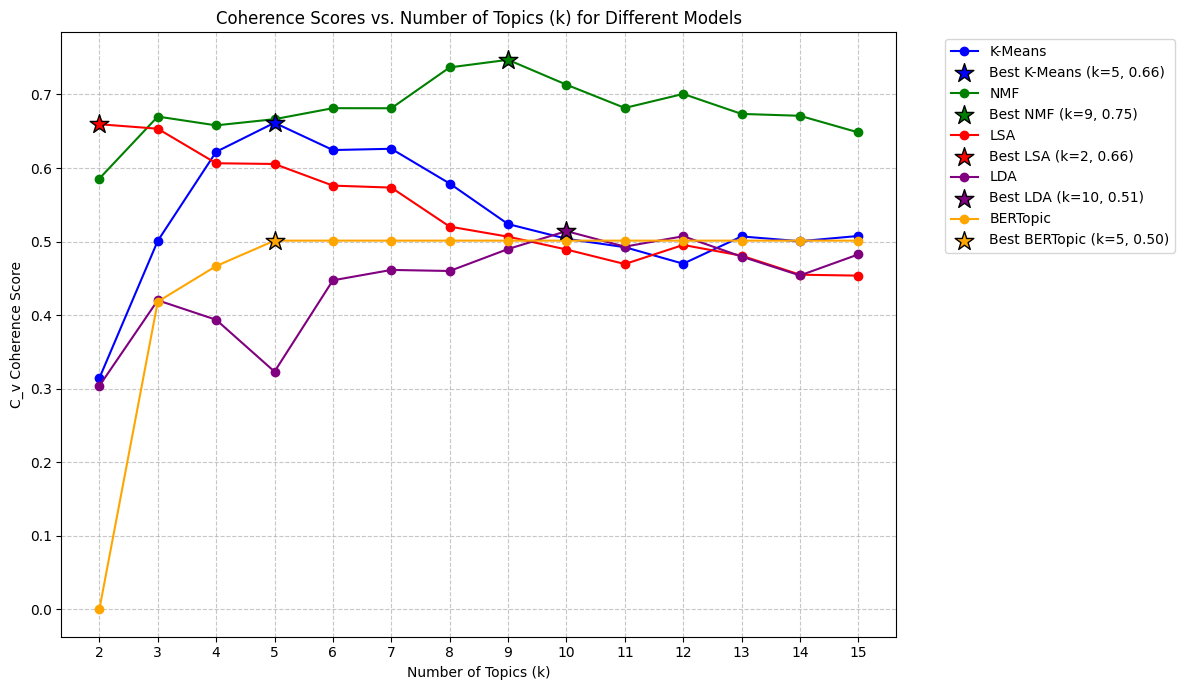

In [ ]:
print("\n--- Visualizing Coherence Scores vs. Number of Topics (k) ---")

plt.figure(figsize=(12, 7))

# Plot K-Means
if kmeans_coherence_per_k:
    k_values = [res['k'] for res in kmeans_coherence_per_k]
    coherence_scores = [res['coherence'] for res in kmeans_coherence_per_k]
    plt.plot(k_values, coherence_scores, marker='o', label='K-Means', color='blue')
    plt.scatter(best_k_kmeans, best_kmeans_score, marker='*', s=200, color='blue', edgecolor='black', zorder=5, label=f'Best K-Means (k={best_k_kmeans:.0f}, {best_kmeans_score:.2f})')

# Plot NMF
if nmf_coherence_per_k:
    k_values = [res['k'] for res in nmf_coherence_per_k]
    coherence_scores = [res['coherence'] for res in nmf_coherence_per_k]
    plt.plot(k_values, coherence_scores, marker='o', label='NMF', color='green')
    plt.scatter(best_k_nmf, best_nmf_score, marker='*', s=200, color='green', edgecolor='black', zorder=5, label=f'Best NMF (k={best_k_nmf:.0f}, {best_nmf_score:.2f})')

# Plot LSA
if lsa_coherence_per_k:
    k_values = [res['k'] for res in lsa_coherence_per_k]
    coherence_scores = [res['coherence'] for res in lsa_coherence_per_k]
    plt.plot(k_values, coherence_scores, marker='o', label='LSA', color='red')
    plt.scatter(best_k_lsa, best_lsa_score, marker='*', s=200, color='red', edgecolor='black', zorder=5, label=f'Best LSA (k={best_k_lsa:.0f}, {best_lsa_score:.2f})')

# Plot LDA
if lda_coherence_per_k:
    k_values = [res['k'] for res in lda_coherence_per_k]
    coherence_scores = [res['coherence'] for res in lda_coherence_per_k]
    plt.plot(k_values, coherence_scores, marker='o', label='LDA', color='purple')
    plt.scatter(best_k_lda, best_lda_score, marker='*', s=200, color='purple', edgecolor='black', zorder=5, label=f'Best LDA (k={best_k_lda:.0f}, {best_lda_score:.2f})')

# Plot BERTopic (now with varying k)
if bertopic_coherence_per_k:
    k_values = [res['k'] for res in bertopic_coherence_per_k]
    coherence_scores = [res['coherence'] for res in bertopic_coherence_per_k]
    plt.plot(k_values, coherence_scores, marker='o', label='BERTopic', color='orange')
    plt.scatter(best_k_bertopic, best_bertopic_score_k, marker='*', s=200, color='orange', edgecolor='black', zorder=5, label=f'Best BERTopic (k={best_k_bertopic:.0f}, {best_bertopic_score_k:.2f})')

plt.title('Coherence Scores vs. Number of Topics (k) for Different Models')
plt.xlabel('Number of Topics (k)')
plt.ylabel('C_v Coherence Score')
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

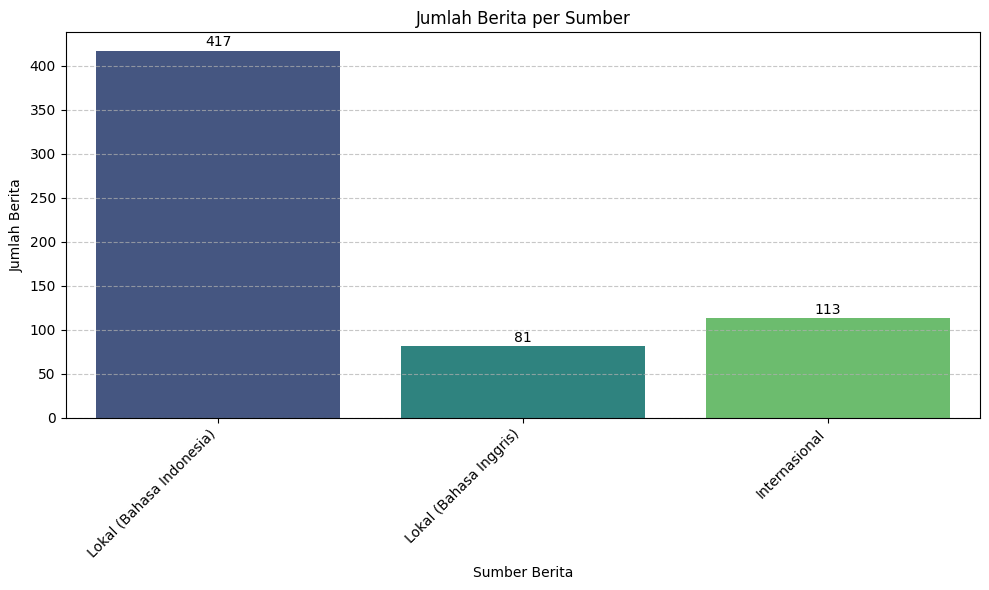

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data yang diberikan
data = {
    'Sumber Berita': ['Lokal (Bahasa Indonesia)', 'Lokal (Bahasa Inggris)', 'Internasional'],
    'Jumlah Berita': [417, 81, 113]
}

df_sumber_berita = pd.DataFrame(data)

# Buat grafik batang
plt.figure(figsize=(10, 6))
sns.barplot(x='Sumber Berita', y='Jumlah Berita', data=df_sumber_berita, palette='viridis')
plt.title('Jumlah Berita per Sumber')
plt.xlabel('Sumber Berita')
plt.ylabel('Jumlah Berita')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan label nilai di atas setiap batang
for index, row in df_sumber_berita.iterrows():
    plt.text(index, row['Jumlah Berita'] + 5, str(row['Jumlah Berita']), color='black', ha="center")

plt.tight_layout()
plt.show()

In [ ]:
print("=== Perbandingan Coherence Score Berdasarkan Jumlah Topik (K) ===")

# Convert coherence results for each model to DataFrames
df_kmeans = pd.DataFrame(kmeans_coherence_per_k).rename(columns={'coherence': 'KMeans'})
df_nmf = pd.DataFrame(nmf_coherence_per_k).rename(columns={'coherence': 'NMF'})
df_lsa = pd.DataFrame(lsa_coherence_per_k).rename(columns={'coherence': 'LSA'})
df_lda = pd.DataFrame(lda_coherence_per_k).rename(columns={'coherence': 'LDA'})
df_bertopic = pd.DataFrame(bertopic_coherence_per_k).rename(columns={'coherence': 'BERTopic'})

# Merge all DataFrames on 'k'
combined_df_coherence = df_kmeans.merge(df_nmf, on='k', how='outer') \
                                 .merge(df_lsa, on='k', how='outer') \
                                 .merge(df_lda, on='k', how='outer') \
                                 .merge(df_bertopic, on='k', how='outer')

combined_df_coherence.rename(columns={'k': 'Jumlah Topik (K)'}, inplace=True)

# Sort by 'Jumlah Topik (K)' for better readability
combined_df_coherence.sort_values(by='Jumlah Topik (K)', inplace=True)

display(combined_df_coherence)

=== Perbandingan Coherence Score Berdasarkan Jumlah Topik (K) ===


Jumlah Topik (K)    KMeans       NMF       LSA       LDA  BERTopic
0                  2  0.314226  0.585637  0.659556  0.303791  0.000000
1                  3  0.500905  0.669977  0.653464  0.420133  0.418290
2                  4  0.622036  0.658026  0.606496  0.393661  0.466674
3                  5  0.661529  0.666444  0.605511  0.323122  0.501269
4                  6  0.624454  0.681383  0.576074  0.447304  0.501269
5                  7  0.626172  0.681296  0.573398  0.461429  0.501269
6                  8  0.578926  0.736842  0.520336  0.459987  0.501269
7                  9  0.523779  0.747168  0.506653  0.489850  0.501269
8                 10  0.503804  0.713341  0.489196  0.514192  0.501269
9                 11  0.492357  0.681700  0.469432  0.493096  0.501269
10                12  0.469902  0.700748  0.495414  0.507251  0.501269
11                13  0.506971  0.673581  0.480774  0.479586  0.501269
12                14  0.500464  0.671028  0.454944  0.453929  0.501269
13                15  0.507622  0.648394  0.453688  0.482541  0.501269